<a href="https://colab.research.google.com/github/vsojo/covid19/blob/master/Covid19_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![American Museum of Natural History](https://raw.githubusercontent.com/vsojo/covid19/master/_img/AMNH_Logo_128x128.png)

# An agent-based network model of SARS-CoV-2 spread
**[ This model is under construction, please stay tuned, or [contact us](mailto:vsojo@amnh.org) to collaborate! ]**

# Quick instructions to use this code
1.  If you are seeing this on GitHub, please click on the link above to "Open in Colab", or follow [this link](https://colab.research.google.com/github/vsojo/covid19/blob/master/Covid19_model.ipynb).
1. Once in Google Colab, click **Runtime > Run all** from the top menu.
  * **Note:** You will be asked to log in to a Google account to be able to run and modify the code (sorry about that!). You will also be given a warning that Google did not develop this code, and that we may access your Google data (we do not!); you're also encouraged to check the code before you run, please do that, of course. Ultimately, you'll have to accept the warning (sorry about that too).
1. The output of the model is at the end. You can then go back and modify the parameter values, but **please do not hit the play ▷ button** on any of the dashboard cells, just modify the values in the sliders and boxes and then click play ▷ only at the end. If you do click play, that will reset the dashboard and you'll have to choose your desired values again.
1. With your desired values selected, click play ▷ only on the last two boxes. The first one has the main code, the second one plots the social networks of infection.

Please read along for further details, and please contact us if you find any errors in this material or have any suggestions for improvement.

## Technical foreword: Running the model
This model is a Jupyter Notebook developed in Google Colab. If you are seeing it anywhere else (e.g. GitHub), you may want to consider [opening it in Colab](https://colab.research.google.com/github/vsojo/covid19/blob/master/Covid19_model.ipynb).

You can browse the model and some output just like you would a passive website. But you can also change parameters and run it yourself. To run the model once you're in Colab, you will need to log in with a Google-enabled account (apologies for that limitation). Then you will need to click **Runtime > Run all** in the menu at the top left.

You will be given a warning that Google did not develop this code (because they didn't – [we](#contributors) did). You will need to accept this warning if you wish to run the code. Otherwise you should still be able to browse this document, but you will not be able to change or execute the code beyond that.

Alternatively, if you are familiar Jupyter Notebooks, you can freely download this document (which contains the whole model) from either Colab or GitHub, but you may need to modify a few Google-specific bits (chiefly Google Widgets, which may not run on normal Jupyter).

## Controling the parameters
You can alter any parameters that you decide in the dashboards below. All the code is included within this document itself, so you can essentially alter everything in your own copy of the code. However, the code is generally hidden. Wherever there is hidden code, e.g. in the dashboards, **you can double click on the dashboard to edit its code**. You can then double-click again to hide the code, or use **Edit > Show/hide code** in the main menu at the top.

**Note:** if you wish to alter the code here, you will need to copy this document to your own Google Drive and save it there, then you should be able to change your copy at will. Please feel free to modify anything you wish, you won't affect our original code. If you come up with any suggestions for improvement or want to collaborate, we would very much welcome it if you [contact us](mailto:vsojo@amnh.org). If you are familiar with GitHub, you can also share your suggestions with us there.

# Introduction
This model seeks to minimally reproduce the behaviour of a system in which there are people living in cities, and there is an infection meant to mimic the 2020 Covid-19 crisis. People meet other people and get infected or pass on their infections. They also recover, or they can get worse and require hospitalisation, or even a ventilator. People may also die. Existing health pre-conditions and the unavailability of hospital beds/ventilators increase the risk of becoming worse and of dying.

Ultimately, **the objective of the model is to allow customisation in the study of the epidemiological behaviour of a pandemic, as well as the effects of different social measures**, such as what happens when people self-isolate, when travel to other cities (which may have their own infections going on) is restricted or allowed again, or local lockdowns are imposed that restrict how many people each person meets every day.

This model is (constantly) under development. A list of [contributors](#contributors) is presented at the end of this document. If you have any suggestions for improvement or would like to collaborate, please leave your comments on Colab, on GitHub, or via email at vsojo@amnh.org

In [1]:
#@title Libraries, imports [double click here to show/hide code]
#################
#   LIBRARIES   #
#################
# Utilities
from collections import defaultdict
# Widgets, GUIs:
import ipywidgets
from IPython.display import display
from google.colab import widgets as gwidgets
# Maths, stats, random numbers
import math
import numpy as np
import pandas as pd
import random
from scipy.stats import poisson
# Plotting
from matplotlib import pyplot as plt
# Social Networks:
import networkx as nx
import plotly.graph_objects as go

In [2]:
#@title Helper functions [double click here to show/hide code]

##############################
#  RANDOM-NUMBER GENERATION  #
##############################
N_RANDS = 100
def get_rand():
    """Returns a random number between 0 and 1"""
    if len(rands) == 0:
        # fill up the list of random numbers if it's empty
        rands.extend(np.random.rand(N_RANDS))
    return rands.pop()
# end def: get_rand()

def load_file_to_dict_of_lists(file, key_col=0, data_start_col=1, data_end_col=None, sep='\t', skip=0, skipchar='#', get_header=False, parseint=False, parsefloat=False):
  """
  Reads a file and makes the index_col the key of a dictionary,
  and fits the data starting from data_start_col as a list of values
  """
  out_dict = dict()
  
  with open(file, 'r') as f:
    while skip:
      # Skip lines at the beginning of the file
      next(f)
      skip -= 1

    # Now read the rest of the file line by line
    for line in f:
      fields = line.strip().split(sep)
      # Get the key
      key = fields[key_col]

      # if an ending column was specified, use it
      if data_end_col:
        out_dict[key] = fields[data_start_col:data_end_col+1]
      else: # otherwise just get everything
        out_dict[key] = fields[data_start_col:]
      # end if: extracting data columns
    # end for: reading file line by line
  # end with: processing the file

  # Return the dictionary that was just built
  return out_dict
# end def: load_file_to_dict_of_lists()

In [3]:
#@title Constants and global variables [double click here to show/hide code]
########################
#  GENERAL CONTSTANTS  #
########################
N_CITIES = 5
F = 0 # Female
M = 1 # Male
KEEP_LOGS = False

#####################################
#  PERSON - DISEASE/SYMPTOM STATUS  #
#####################################
HEALTHY   = 501 # Does not have an active Infection (but may have pre-existing conditions)
MILD      = 502 # 
UNWELL    = 503 # 
SEVERE    = 504 # Needs a hospital bed
CRITICAL  = 505 # Requires an ICU

#######################################
#  INFECTION - SUSCEPTIBILITY STATUS  #
#######################################
SUSCEPTIBLE   = 100 # The person can catch a Pathogen
EXPOSED       = 101 # the Person has been exposed to the Pathogen, but is not yet contagious.
INFECTIOUS    = 102 # actively contagious at present
IMMUNE        = 103 # equivalent to "recovered" in a typical SEIR model. Using "immune" here because "recovered" can be ambiguous when considering symptoms
LATENT        = 104 # The Person has had the Pathogen and is not contagious at present, but may become so again at some point
RESUSCEPTIBLE = 105 # In case the infection can be reacquired, but at a lower/different susceptibility, otherwise SUSCEPTIBLE can be used
# A couple more infection trackers
ALL_INFECTED     = 200 # Anyone who has ever been infected
DAILY_INFECTIONS = 201 # How many infections occur on each day
R_VALUE          = 203 # Changes in the R value throughout time
R_VALUE_RUN_AVG  = 204 # Smooth average (convolution) of the R value

################################
#  INFECTION - SYMPTOM STATUS  #
################################
ASYMPTOMATIC  = 300
MILD          = 301
SEVERE        = 302


################################
#       GLOBAL VARIABLES       #
################################
rands         = [] # A list of (pseudo) random numbers, for quick access
CITIES        = [] # A list of all City objects

# Description of the model
This is an individual-based or agent-based model. That means that the model tracks the health and behaviours of each person individually, and the events in each city one by one.
There are four (4) main types of entity (or "objects") in this model: **Person**, **City**, **Pathogen**, and **Infection**. 
+ Objects of the **`Person`** class have properties such as age, health status, whether or not they are infected, and more. At each iteration, they can go out, meet other people, get infected, their health can get better or worse, they can travel to other cities, and more.
+ Objects of the **`City`** class contain objects of the Person class. Cities can take actions such as impose lockdown, cancel travel to other cities, and so on. Cities also have intrinsic qualities such as how social people are, what population distribution (pyramid) the ages of its citizens follow, and more. In a minimal case, the model may have only one city.
+ Objects of the **`Pathogen`** class contain specifications about epidemiological and biological factors, such as duration of symptoms, infectivity per contact, and more. In the basic version of the model there is only one Pathogen.
+ Objects of the **`Infection`** class track the processes in which a `Pathogen` is acquired by a `Person`, and contain details such as how long ago it was acquired, whether it is presently latent, contagious, immunised, or if the person is susceptible to it again.

These classes are described in further detail below. But first, we address (and write code for) age distributions.

## Infection (SEIRS compartments) and Disease/Symptom status progression
An infection in the model progresses as described in the following diagram:

![Infection status sequence (SEIRS)](https://raw.githubusercontent.com/vsojo/covid19/master/_img/SEIRS_and_disease_sequence.png)

The diagram has two parts. The top section describes the progression of the infection itself, regardless of the carrier's health status. The model is similar to a traditional **SEIRS** model. That is, there are or *compartments*\* through which the infection progresses as time passes. These are described next:

A `Person` is by default **`SUSCEPTIBLE`** to the `Pathogen`. A `SUSCEPTIBLE` `Person` can be **`EXPOSED`** to the `Pathogen`. At this point, an `Infection` starts and, after a number of days, the `Person` becomes **`INFECTIOUS`**, which means they can infect others with the `Pathogen`. Some time after that, the `Person` becomes **`IMMUNE`** (typically known as *recovered* in a SEIRS model\*\*) and stops  transmitting the `Pathogen`. Immunity may then last for life; but if this is not the case, some time after becoming immune the Person may lose _all_ immunity and become `SUSCEPTIBLE` again. Alternatively, it is possible that the `Person` only partly loses immunity and can be reinfected, but at a lower probability than if never infected; we code this here as being `RESUSCEPTIBLE`, but by default immunity is assumed to last for life.

The second section **has not been implemented yet**, but it describes the progression of symptoms and health, potentially leading to death. Here, this is treated as unrelated to the progression of the `Infection` itself, except for the fact that health may begin to deteriorate only after exposure to the `Pathogen`. A `Person` may be **asymptomatic** (not shown in the figure), which in the present version of the model **does not affect how contagious they are**. Alternatively, they may develop symptoms that can progress from **Mild** (the `Person` still goes out and meets people, but their probability of doing so may diminish), to **Unwell** (the `Person` has intense symptoms but these can still be self-managed by staying home), to **Severe** (the `Person` needs to be hospitalised), and finally **Critical** (which means the person needs an Intensive Care Unit, ICU).

At any point after developing symptoms, a `Person` may die because of its `Infection` with the `Pathogen`, with increasing probability depending on the severity of the symptoms. In this model, a **Healthy** `Person` without symptoms cannot die, i.e. the only cause of death in the model is the `Pathogen`, and only symptomatic people can die. In that sense, the Healthy status includes people who have never carried the `Pathogen` (`SUSCEPTIBLE`), those who presently have an `Infection` (`EXPOSED`, `INFECTIOUS`) but are asymptomatic, and those who had it and are no longer infectious (are now `IMMUNE`). Note that a `Person` can continue to have symptoms long after their infection has passed, i.e. long after they have become `IMMUNE`; as discussed below, this is the main reason why we do not use the "recovered" category from traditional SEI**R**S modelling for people who have acquired immunity, since we judge that it can be confusing given that we are tracking health deterioration separately.

\***Compartments:** technically, the infectivity statuses described in the figure are known in the epidemiology modelling literature as "compartments", but please do not confuse them with _geographical_ or _spatial_ compartments. This model does not take into account space or distance other than travel between cities. Each `City` is treated as a homogeneous bag without any internal structure -- anyone can meet anyone else in the `City` on any given day.
\*\***Recovered:** We are avoiding the term "recovered" because it can be prone to misinterpretation when dealing with the health status. As evidenced in the 2020 COVID-19 crisis, a `Person` may complete the infection cycle but still struggle with recovery from the effects of having had an `Infection` of the `Pathogen`.

# Age distribution
The ages of people in each city are sampled from a population pyramid.

You can choose from a few example pyramids that are pre-computed into the model, or you can enter details of your own **Custom** pyramid.

The pyramids are presently defined as symmetric by sex (i.e. there are no differences between the distributions of men and women). You can explore the types in the following tabs, and then choose your desired type below.

**Note:** The pyramids are presented as probability density functions of being a certain age.

# The **Person** class
## Properties of a Person (_attributes_)
Persons have a number of properties, such as:
* Age (which has an inverse relation to the chance of surviving).
+ Whether or not they are infected.
+ Typical number of daily contacts (i.e. how many people they would meet on a given day on average. This number would change depending on the city's ordinances, whether the person is showing symptoms, has tested positive, or is hospitalised).
+ Health status (are they healthy, ill, very ill, or critical?).
+ Home City (which they have a high chance of returning to when they leave, in case there is more than one city in the model).
+ ...and more (see the description of the Person class below).

## Actions of a Person (_methods_)
* A person can die, regarless of whether or not they had the virus.
+ However, a person's chances of dying increase with:
    * Age.
    + Pre-existing conditions (these are described abstractly as an integer, with the default being zero - i.e. no pre-conditions. One pre-condition increases the chances of worsening and of dying, two increase it further, and so on.
    + Unavailability of a hospital bed or ventilator.
    + Infection status.
    + Health condition (higher is worse).

## Person class diagram
<table class="class_diagram">
    <tr>
        <th>Attributes of Person class</th>
    </tr>
    <tr class="attributes" title="Each Person has a unique identifier.">
        <td><code>+ id: int</code></td>
    </tr>
    <tr title="The age of the individual. Any individual can die. The older the individual, the more likely it is to die.">
        <td><code>- age: int</code></td>
    </tr>
    <tr title="Which City this Person comes from.">
        <td><code>- home_city: City</code></td>
    </tr>
    <tr title="Which City this Person currently is in.">
        <td><code>- current_city: City</code></td>
    </tr>
    <tr title="Has the individual been infected at some point?">
        <td><code>- has_been_infected: bool = False</code></td>
    </tr>    
    <tr title="How many days since the individual was infected. If -1, it hasn't been infected. 0 when just infected.">
        <td><code>- days_since_infection: int = -1</code></td>
    </tr>  
    <tr title="By default, an individual is not infected and therefore not infectious. This can change upon infection, and again upon recovery.">
        <td><code>+ is_infectious: bool = False</code></td>
    </tr>    
    <tr title="A person can have the virus without showing any symptoms, or show similar symptoms without having the virus. A person with symptoms reduces their social contacts.">
        <td><code>- has_symptoms: bool = False</code></td>
    </tr>
    <tr title="By default, an individual is vulnerable, unless it has been infected and recovered, or vaccinated effectively.">
        <td><code>- is_immune: bool = False</code></td>
    </tr>
    <tr title="HEALTHY=1, ILL=2 (tends to stay at home), VERY_ILL=3 (requires a hospital bed), CRITICAL=4 (requires a ventilator)">
        <td><code>- health_condition: int = HEALTHY</code></td>
    </tr>
    <tr title="The more preconditions a person has, the worse it is affected by infection.">
        <td><code>- n_preconditions: int = 0</code></td>
    </tr>
    <tr title="How many people does this person meet every day, under normal conditions.">
        <td><code>- n_daily_contacts: int = 50</code></td>
    </tr>
    <!--
                  METHODS of the Person class    
    -->
    <tr style="border-top: 1px solid black">
        <th>Methods of Person class</th>
    </tr>
    <tr class="methods" title="the constructor of the class.">
        <td><code>- Person()</code></td>
    </tr>
    <tr title="Effectively, this works as the 'destructor' of the class. Any bed or ventilator is freed, the tally is increased. A death crisis may also be modelled, following reports from Ecuador, Italy and other places where funerary services have become overwhelmed.">
        <td><code>- die()</code></td>
    </tr>
    <tr>
        <td><code>- get_infected()</code></td>
    </tr>
    <tr>
        <td><code>- become_critical()</code></td>
    </tr>
    <tr title="">
        <td><code>- go_outside()</code></td>
    </tr>
    <tr>
        <td><code>+ meet_person(bool: is_person_infectious)</code></td>
    </tr>
    <tr title="In an early version of the model, this just sends Person to a migration blackbox, where they can get infected and from where they can come back. In a more complex version of the system, with multiple cities, the individual can visit other cities and get infected or bring an infection there.">
        <td><code>+ go_to_city(destination_city)</code></td>
    </tr>
</table>

In [4]:
#@title Code for the Person class [double-click here to show/hide code]
class Person:
  ###############
  # CONSTRUCTOR #
  ###############
  def __init__(self, **kwargs):
    # REQUIRED PARAMETERS THAT MUST BE PASSED IN UPON INSTANTIATION (CONSTRUCTION)
    required_params = {
      'home_city'       : "an object of class City",
      'age'             : "an integer, zero or higher",
      'n_preconditions' : "an integer, zero or higher",
      'n_daily_contacts': "an integer, zero or higher"
    }
    if not all([param in kwargs for param in required_params]):
      joiner = "\n\t- "
      raise AttributeError("This Person needs to receive the following arguments upon creation:\n"
        + joiner + joiner.join(required_params))
    self._home_city         = kwargs['home_city']
    self._age               = kwargs['age']
    self._n_preconditions   = kwargs['n_preconditions'] if 'n_preconditions' in kwargs else 0
    self._n_daily_contacts  = kwargs['n_daily_contacts']
    
    self._log_ = f"I was born in City {self._home_city}\n"
    # Other parameters that can be set upon instantiation
    self._current_city = kwargs['current_city'] if 'current_city' in kwargs else self._home_city

    self._DESIRED_MEETINGS = kwargs['DESIRED_MEETINGS'] if 'DESIRED_MEETINGS' in kwargs else 10
    self._remaining_meetings = None
    
    #  INFECTIONS  #
    # A list of all ongoing and previous Infections that this person has or has had
    self._infections = kwargs['infections'] if 'infections' in kwargs else {}

    self._health_condition = kwargs['health_condition'] if 'health_condition' in kwargs else HEALTHY # could also be MILD, UNWELL, SEVERE, CRITICAL
    self._is_in_hospital = kwargs['is_in_hospital'] if 'is_in_hospital' in kwargs else False
    self._has_hospital_bed = kwargs['has_hospital_bed'] if 'has_hospital_bed' in kwargs else False
    self._has_icu = kwargs['has_icu'] if 'has_icu' in kwargs else False
    #self._ = kwargs[''] if '' in kwargs else 
    # RegEx to change list of attributes into kwargs extraction or default value:
    # SEARCH:[+-] ([\w]+): [\w]+ = (.*) REPLACE:self._\1 = kwargs['\1'] if '\1' in kwargs else \2
    
    # OTHER ATTRIBUTES TO SET UPON INITIALISATION
    self._was_at_superspreader = set()
  # end def __init__: CONSTRUCTOR of the class

  #def __str__(self):
  #  return f"This is Person #{id(self)}, aged {self.age()}, from City #{self.home_city().name()}"
  def __repr__(self):
    return f"Person:{id(self)}|age:{self.age()}|HomeCity:{self.home_city().name()}"
  
  ##############
  # DESTRUCTOR #
  ##############
  def __del__(self):
    """This function is equivalent to death of the Person object.
    Upon destruction, a Person releases any bed or ICU occupied.
    """
    if self._has_hospital_bed:
      self._current_city.release_hospital_bed()
    if self._has_icu:
      self._current_city.release_icu()

    # log the statistics of this person's death:
    #self._current_city.log_death(self)
  # end def __del__ : DESTRUCTOR of the class

  #########################
  # GETTER/SETTER METHODS #
  #########################
  def log(self, text_to_add=None):
    if not KEEP_LOGS:
      return None
    if text_to_add != None:
      self._log_ += text_to_add
    return self._log_
  def age(self, set__age=None):
    if set__age: self._age = set__age
    return self._age
  def home_city(self):
    return self._home_city
  def current_city(self, set__current_city=None):
    if set__current_city: self._current_city = set__current_city
    return self._current_city
  def health_condition(self, set__health_condition=None):
    if set__health_condition: self._health_condition = set__health_condition
    return self._health_condition
  def n_preconditions(self, new_n_preconditions=None):
    if new_n_preconditions: self._n_preconditions = new_n_preconditions
    return self._n_preconditions

  def has_symptoms(self, new_has_symptoms=None):
    if new_has_symptoms: self._has_symptoms = new_has_symptoms
    return self._has_symptoms  

  def infections(self, pathogen=None):
    if pathogen:
      if pathogen in self._infections:
        return self._infections[pathogen]
      else:
        return None
    return self._infections
  
  def n_daily_contacts(self, set__n_daily_contacts=None):
    if set__n_daily_contacts: self._n_daily_contacts = set__n_daily_contacts
    return self._n_daily_contacts
  def remaining_meetings(self, set__remaining_meetings=None):
    if set__remaining_meetings: self._remaining_meetings = set__remaining_meetings
    return self._remaining_meetings
  def was_at_superspreader(self, superspreader_day=None):
    if superspreader_day:
      self._was_at_superspreader.add(superspreader_day)
    return self._was_at_superspreader
  # RegEx to create getter-setter method:
  # REPLACE:def \1(self, new_\1=None):\n  if new_\1: self._\1 = new_\1\n  else: return self._\1
  # END GETTER SETTER METHODS FOR THE PERSON CLASS


  #######################################
  #  OTHER METHODS OF THE PERSON CLASS  #
  #######################################
  def start_day(self):
    """
    Do anything that needs to be done at the start of a day,
    such as resetting the number of daily meetings, and
    increasing the Pathogen day counters.
    """
    # Desired meetings for this day
    self._remaining_meetings = self._DESIRED_MEETINGS

    #####################################
    # Infection and Symptom progression #
    #####################################
    for infection in self._infections.values():
      infection.add_day()

      ##### INFECTION PROGRESSION #####
      # Now check if the number of days that have passed mean
      # that the status needs to change
      # make INFECTIOUS if EXPOSED (i.e. exposed in traditional SEIR models) and passed necessary days, 
      if infection.status() == EXPOSED and infection.days_since_acquired() >= infection.pathogen().days_until_contagious():
        # set the Person's Infection status to INFECTIOUS
        infection.status(INFECTIOUS)
        # Change the status tracker
        self._current_city.person_status_changed(person=self, pathogen=infection.pathogen(), status_from=EXPOSED, status_to=INFECTIOUS)
      # if INFECTIOUS and passed necessary days, make IMMUNE
      elif infection.status() == INFECTIOUS and infection.days_since_acquired() >= infection.pathogen().days_until_not_contagious():
        infection.status(IMMUNE)
        self._current_city.person_status_changed(person=self, pathogen=infection.pathogen(), status_from=INFECTIOUS, status_to=IMMUNE)
      # if IMMUNE &and& can be reinfected &and& passed necessary days, make RESUSCEPTIBLE
      elif infection.status() == IMMUNE and infection.pathogen().days_until_resusceptible() > 0 and infection.days_since_acquired() >= infection.pathogen().days_until_resusceptible():
        infection.status(RESUSCEPTIBLE)
        self._current_city.person_status_changed(person=self, pathogen=infection.pathogen(), status_from=IMMUNE, status_to=RESUSCEPTIBLE)
      # end if: changing the infection status and updating the trackers in the current city




      ##### SYMPTOM PROGRESSION ######
      if self._health_condition == HEALTHY  and  infection.days_since_acquired() == infection.pathogen().days_until_symptoms():
        if get_rand() < infection.pathogen().p_symptomatic():
          # The Person becomes symptomatic
          self.change_health(health_from=HEALTHY, health_to=MILD)
          #print(f"{self} becomes symptomatic!")
        # end if: does the person become symptomatic (at random)?
      # end if: have enough days passed for a HEALTHY Person to become symptomatic?

      if self._health_condition in [MILD, UNWELL, SEVERE]:
        rand = get_rand()
        p_improve = infection.pathogen().p_symptom_progression(self._health_condition)[0]
        p_stay    = infection.pathogen().p_symptom_progression(self._health_condition)[1]# cumulative probability of staying in the current state
        # The probabilities in the two-value sliders work as follows:
        # 0.0         0.2                    0.8          1.0
        #  |  improve  |         stay         |   worsen   |
        #          _-^-_
        #   e.g. rand=0.16
        # would mean the person improves

        if rand < p_improve:
          # The Person gets better, so symptom status decreases by 1
          self.change_health(health_from=self._health_condition, health_to=self._health_condition-1)
        elif rand > p_stay:
          # The Person gets worse, and progresses to the next symptom status
          self.change_health(health_from=self._health_condition, health_to=self._health_condition+1)
        # otherwise the Person just stays in their current health status
      elif self._health_condition == CRITICAL:
        if get_rand() < infection.pathogen().p_symptom_progression(CRITICAL):
          # The Person recovers to SEVERE
          self.change_health(health_from=CRITICAL, health_to=SEVERE)
        # end if: intermediate states (MILD, UNWELL, WEVERE) vs. CRITICAL
      # end if: symptomatic states
      
    # end for: checking infection by infection for daily progress of infectivity and symptoms

  # end def: start_day()

  def change_health(self, health_from, health_to):
    """
    Handles changes in the health status of a Person. This can include requesting/releasing
    hospital beds and ICUs when moving to/from the UNWELL/SEVERE/CRITICAL statuses, changing
    the nubmers of people the Person meets each day (e.g. by decreasing it if UNWELL, or
    restoring it to normal if returning to HEALTHY), and so on.
    """
    # Change the health condition to the new one, but there may be caveats
    # to deal with if there are no available hospital beds or ICUs (below)
    self._health_condition = health_to
    
    if health_to == UNWELL and health_from == SEVERE:
      # Person is recovering and being discharged from hospital (if there),
      # so release the hospital bed
      if self._has_hospital_bed:
        self._release_hospital_bed()
    if health_to == SEVERE:
      # Coming from either UNWELL or CRITICAL
      # In either case, need a hospital bed. Attempt to assign one:
      if self._get_hospital_bed():
        # There is a hospital bed available, and it was assigned
        if health_from == CRITICAL:
          #  Health has improved, so Person can leave the ICU
          self._release_icu()
        elif health_from == UNWELL:
          # Health deteriorates and Person needs a hospital bed, which was
          # already assigned above, so just pass for now
          pass
        # end if: checking that there is a hospital bed
      # else: There is no hospital bed available, so those who were UNWELL will
      # have to stay home, and those who were CRITICAL will have to stay in ICU
    elif health_to == CRITICAL:
      # Must be coming from SEVERE
      # Ask the current City for an ICU, and assign it if available:
      if self._get_icu():
        # Successful assigning an ICU, so if the Person had a
        # hospital bed assigned, release it
        if self._has_hospital_bed:
          self._release_hospital_bed()
        # end if: release hospital bed if has one
      # end if: successful assigning ICU? If not, hold on to hospital bed if has one


    problem = False
    # e.g. if 
    if not problem:
      
      return True
    else:
      return False
  # end def: change_health()

  def _get_hospital_bed(self):
    """Requests a hospital bed from the current City and returns True if found, False if not"""
    if self._current_city.assign_hospital_bed(person=self):
      # Successful, so mark that Person now has a bed and return True
      self._has_hospital_bed = True
      return True
    else:
      # There was no bed available, return False
      return False
  # end def: _get_hospital_bed()

  def _get_icu(self):
    """Requests an Intensive Care Unit (ICU) from the current City and returns True if available, False if not"""
    if self._current_city.assign_icu(person=self):
      # Successful, so take note that Person now has an ICU and return True
      self._has_icu = True
      return True
    else:
      # There was no ICU available, return False
      return False
  # end def: _get_icu()
  
  def _release_hospital_bed(self):
    """Releases a hospital bed back to the current City"""
    self._current_city.release_icu(person=self)
  # end def: _release_hospital_bed()
  
  def _release_icu(self):
    """Releases an ICU back to the current City"""
    self._current_city.release_icu(person=self)
  # end def: _release_icu()
  

  def decrease_meetings(self, n=1):
    """Decreases the counter of meetings remaining for this Person by n."""
    self._remaining_meetings -= n
  # end def: decrease_meetings
  
  def get_infected(self, pathogen, infected_by, infection_day):
    """Adds an Infection of this Pathogen to this Person's list of Infections."""
    self._infections[pathogen] = Infection(pathogen=pathogen, infected_by=infected_by, infection_city=self._current_city, infection_day=infection_day)
  # end def: get_infected)

# The **City** Class
+ Persons live in a **City**, the second unit in the model (but initially there is only one city).
+ The city has a number of properties, such as:
    * How social people are (i.e. how many people each person is likely to meet each day, as a distribution around an average).
    + How many hospital beds and ventilators there are
    + How many of those beds and ventilators are currently available.
    + Optionally, which cities this city is connected to and how intensely (initially there is only one city and migration is dealt-with in an abstract manner, see below).
    + How many people emigrate from the city at any given iteration (by default, the number of people who migrate back in is the same, so that no people are lost by migration).
+ The City also has a number of actions it can perform (full list below), for example:
    * Whether tests are being performed (people who test positive are more likely to stay at home. If the model is networked, then the a percentage of the contacts of those people would be informed and their probability of meeting other people would also fall, if possibly by less than for the original tested person).
    + The city can do vaccinations.
    + The city can do serology tests to check who has had an `Infection` of a given `Pathogen`.
+ There are a number of high-risk people in the city. These persons meet far many more people than regular people do. These correspond to e.g. health personnel, bus drivers, grocery store workers, immigration officers, bank tellers, and so on.
+ Although not necessary for the most minimal description of the model, there can be more than one city, and these cities would be connected to each other.
+ As a first approach, though, there is abstract emigration: some people just leave the city, but they may end up in a migration blackbox for "not-in-this-city". People in hospital cannot leave the city.
+ Similarly, other people can come into the city, and these new people would come with their own infectiousness and pre-existing conditions, assigned at random.
+ There are two numbers of meetings being used here:
  1. "**Regular**" (typically most) people in the city meet a given number of people every day, on average.
  1. **High-contact** people typically meet a much higher number of people each day. This could be akin to people working with public (health personnel, public transport employees, retail workers, and so on).

  Both numbers are sampled from a Poisson distribution around each of the two means chosen below, and the proportion of how many people belong to each class can be chosen as well.

## City class diagram
<table class="class_diagram">
    <tr>
        <th>Attributes of the City class</th>
    </tr>
    <tr class="attributes" title="Each City has a unique identifier, which can be used to track connections to other cities, and by Persons to know where they are and where home is.">
        <td><code>+ id: int</code></td>
    </tr>
    <tr title="The list of all people living in this city.">
        <td><code>- people: array of <b>Person</b></code></td>
    </tr>
    <tr title="How many persons live in this city.">
        <td><code>- population: int = &Sigma;#Persons == len(people)</code></td>
    </tr>
    <tr title="How many hospital beds the city regularly has, for each 1 thousand citizens.">
        <td><code>- N_HOSP_BEDS_PER_1K: float = 2.0</code></td>
    </tr>
    <tr title="How many hospital beds the city regularly has, calculated from the number per 1 thousand citizens, above. In a time of crisis, the City may add more beds, and then it may remove those extra beds back down to this number once the crisis is subsiding.">
        <td><code>- N_HOSP_BEDS_ORIGINAL: int</code></td>
    </tr>
    <tr title="How many hospital beds are presently available.">
        <td><code>- n_hosp_beds_available: int</code></td>
    </tr>
    <tr title="How many hospital beds are presently in use.">
        <td><code>- n_hosp_beds_in_use: int</code></td>
    </tr>
    <tr title="How many ventilators the city regularly has, for each 100 thousand citizens.">
        <td><code>- N_VENTILATORS_PER_100K: float = 10.0</code></td>
    </tr>
    <tr title="How many ventilators the city regularly has, calculated from the number per 100 thousand citizens, above. In a time of crisis, the City may add more ventilators, and then it may remove those extra ventilators back down to this number once the crisis is subsiding. Optionally, the City may even go below this number and donate some of its ventilators to another city.">
        <td><code>- N_VENTILATORS_ORIGINAL: int</code></td>
    </tr>
    <tr title="How many ventilators are presently available.">
        <td><code>- n_ventilators_available: int</code></td>
    </tr>
    <tr title="How many ventilators are presently in use.">
        <td><code>- n_ventilators_in_use: int</code></td>
    </tr>
    <tr title="How many people does the average 'regular' Person in this City meet each day? This could be sampled e.g. from a Poisson distribution around this number. Note that there are also high-risk people who meet a lot of people each day, below.">
        <td><code>- group_size_regular: int = 30</code></td>
    </tr>
    <tr title="What proportion of the population are high-contact (e.g. health personnel, public-transport drivers, ?">
        <td><code>- p_high_contact: int = 0.05 (5%)</code></td>
    </tr>
    <tr title="How many people does the average 'high-contact' Person in this City meet each day? This could be sampled e.g. from a Poisson distribution around this number. Note that there are also 'regular' people who meet much fewer people each day, above.">
        <td><code>- group_size_high_contact: int = 500</code></td>
    </tr>
    <tr title="How many comorbidities the average person is born with in this City, sampled from a Poisson distribution. Further comorbidities are added the older the person.">
        <td><code>- birth_comorbidities_poisson_lambda: float = 1.0</code></td>
    </tr>
    <tr title="Which cities is this city connected to?">
        <td><code>- travel_network: list</code></td>
    </tr>
    <tr title="What proportion of the population migrate to another city each day on average?">
        <td><code>- p_migration: int = 0.10 (10%)</code></td>
    </tr>
    <!--
                  METHODS of the City class    
    -->
    <tr>
        <th>Methods of the City class</th>
    </tr>
    <tr title="In a time of crisis, the City may add more beds, and then it may remove those extra beds back down to the original number once the crisis is subsiding.">
        <td><code>- add_hosp_beds(int n_new_beds)</code></td>
    </tr>
    <tr title="Must first check if there aren't people in those beds.">
        <td><code>- remove_hosp_beds(int n_beds_to_remove)</code></td>
    </tr>
    <tr title="In a time of crisis, the City may add more ventilators, and then it may remove those extra ventilators back down to the original number once the crisis is subsiding.">
        <td><code>- add_ventilators(int n_ventilators_to_add)</code></td>
    </tr>
    <tr title="Must first check if there aren't people using those ventilators.">
        <td><code>- remove_ventilators(int n_ventilators_to_remove)</code></td>
    </tr>
    <tr title="Must first check that there aren't people using those ventilators, and that there are enough to donate.">
        <td><code>- donate_ventilators(recipient_city, how_many)</code></td>
    </tr>
    <tr title="This City can ask for ventilators, in the hope that some other City will have and donate them.">
        <td><code>- ask_for_ventilators(how_many)</code></td>
    </tr>
</table>

The following are a few examples of age-distribution pyramids; you can choose or specify your own below.


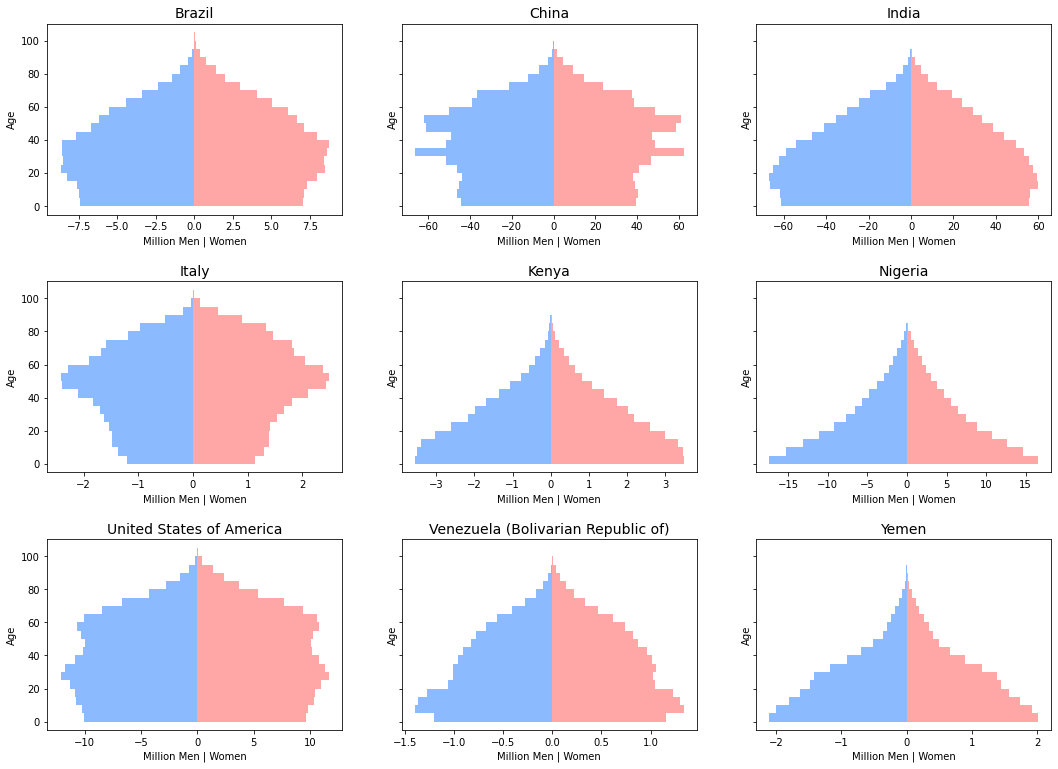

In [5]:
#@title Age distributions (population pyramids) [double-click here to show/hide code]
age_dists_text = """							Population by five-year age group																																									
							F	M	F	M	F	M	F	M	F	M	F	M	F	M	F	M	F	M	F	M	F	M	F	M	F	M	F	M	F	M	F	M	F	M	F	M	F	M	F	M	F	M
Index	Region, subregion, country or area	Notes	Country code	Type	Parent code	Reference date (as of 1 July)	0-4	0-4	5-9	5-9	10-14	10-14	15-19	15-19	20-24	20-24	25-29	25-29	30-34	30-34	35-39	35-39	40-44	40-44	45-49	45-49	50-54	50-54	55-59	55-59	60-64	60-64	65-69	65-69	70-74	70-74	75-79	75-79	80-84	80-84	85-89	85-89	90-94	90-94	95-99	95-99	100+	100+
1740	Afghanistan		4	Country/Area	5501	2020	2765000	2907406	2642000	2774630	2540000	2651664	2252000	2377941	1909000	2017279	1499000	1610796	1179000	1299121	988000	1068167	791000	868020	628000	677226	503000	529188	396000	411379	308000	305081	229000	215637	172000	140254	91000	76897	42000	33115	14000	10185	3000	2053	0	215	0	11
3495	Albania		8	Country/Area	925	2020	80000	86564	80000	87732	75000	86957	93000	106218	111000	117374	115000	129317	101000	122633	76000	90658	77000	75896	90000	80264	96000	88504	103000	98654	95000	91164	74000	69837	56000	52442	45000	41429	28000	25727	13000	10503	4000	2584	1000	242	0	15
1230	Algeria		12	Country/Area	912	2020	2467000	2574062	2269000	2366637	1872000	1949293	1426000	1484482	1469000	1531025	1762000	1812011	1850000	1877520	1765000	1782775	1503000	1511220	1220000	1214095	1035000	1026740	870000	867903	684000	703307	560000	583040	364000	359717	272000	241813	186000	157783	90000	80994	27000	24471	4000	4409	0	511
720	Angola		24	Country/Area	911	2020	2871000	2923514	2536000	2568244	2183000	2166595	1781000	1751828	1458000	1424241	1231000	1192393	1041000	999332	850000	808851	685000	645763	561000	520750	411000	376364	345000	332588	253000	229285	159000	145237	117000	95124	69000	49865	38000	22040	13000	7226	3000	1458	0	161	0	11
2235	Antigua and Barbuda		28	Country/Area	915	2020	4000	3730	4000	3668	3000	3445	3000	3563	4000	3827	4000	3643	4000	3375	4000	3306	4000	3209	4000	3170	4000	3159	3000	2786	2000	2167	2000	1578	1000	1163	1000	741	1000	418	0	217	0	81	0	20	0	3
2640	Argentina		32	Country/Area	931	2020	1833000	1903426	1821000	1889129	1766000	1831221	1740000	1799760	1715000	1762738	1745000	1775210	1660000	1658744	1572000	1550297	1572000	1518156	1360000	1278269	1198000	1103469	1120000	1003393	1007000	877065	899000	745751	758000	578876	578000	385738	406000	228228	251000	113405	114000	38290	28000	7286	3000	695
1350	Armenia		51	Country/Area	922	2020	97000	107883	100000	113643	93000	105888	79000	91231	84000	92927	121000	111248	141000	126226	128000	108316	104000	86905	89000	73107	93000	70401	114000	85257	113000	84196	77000	54592	51000	33796	26000	15945	38000	21033	14000	7813	6000	2977	1000	323	0	40
2250	Aruba	13	533	Country/Area	915	2020	3000	3107	3000	2890	3000	3447	4000	3651	4000	3806	4000	3802	3000	2742	3000	2695	4000	3028	4000	3477	4000	3739	5000	4166	4000	3510	3000	2685	2000	1896	2000	1107	1000	600	0	235	0	53	0	6	0	0
2850	Australia	15	36	Country/Area	927	2020	812000	857499	798000	841026	785000	825846	742000	777475	783000	811222	871000	909705	936000	939585	921000	921591	818000	810368	846000	831536	789000	768934	782000	767400	725000	693712	631000	601807	556000	527592	397000	365811	282000	241273	192000	136756	100000	56263	30000	12306	3000	918
3690	Austria		40	Country/Area	926	2020	218000	230364	206000	219996	205000	218795	219000	233504	246000	263261	295000	312066	305000	315827	308000	314619	281000	284438	307000	305305	356000	357250	347000	346838	298000	284670	237000	213955	220000	187337	215000	168533	153000	107116	90000	52214	47000	19835	13000	3562	1000	206
1365	Azerbaijan	4	31	Country/Area	922	2020	389000	435899	400000	460346	324000	374228	296000	341404	341000	377968	439000	450732	476000	465572	413000	412182	337000	327657	320000	296105	331000	297201	345000	307868	266000	230664	169000	138744	87000	64620	54000	36504	56000	32143	23000	12081	6000	2490	1000	242	0	14
2265	Bahamas		44	Country/Area	915	2020	13000	13896	13000	13649	16000	15659	16000	16178	17000	16718	17000	16567	14000	13846	14000	13070	14000	13237	15000	13764	13000	12140	13000	11138	10000	7956	6000	5358	4000	3543	3000	2362	2000	1297	1000	518	0	163	0	30	0	4
1380	Bahrain		48	Country/Area	922	2020	53000	54608	52000	58503	47000	46133	40000	48537	39000	52816	69000	146431	73000	220224	54000	160056	47000	101279	35000	73440	29000	51983	25000	34121	17000	27656	9000	12509	5000	6141	3000	3415	2000	1789	1000	569	0	237	0	25	0	2
1755	Bangladesh		50	Country/Area	5501	2020	7008000	7320193	7167000	7476957	7382000	7707436	7610000	7975294	7497000	7742470	7268000	7257687	6984000	6778960	6477000	6271177	5672000	5553520	4708000	4718381	4040000	4264730	3221000	3479495	2129000	2371855	1307000	1489609	1150000	1206898	884000	855121	534000	487662	266000	217066	99000	68178	24000	14498	4000	1921
2280	Barbados		52	Country/Area	915	2020	7000	7686	8000	7875	9000	8923	9000	9747	9000	9539	9000	9407	9000	9015	10000	9274	10000	9220	11000	9748	10000	9394	11000	9453	10000	8540	8000	6940	6000	5482	5000	3576	4000	2601	2000	1518	1000	769	0	284	0	93
3150	Belarus		112	Country/Area	923	2020	271000	277400	289000	306942	236000	248915	216000	227984	207000	218608	319000	333729	397000	416816	356000	360742	332000	320970	331000	301557	317000	275420	410000	343489	380000	284767	353000	225597	170000	99113	181000	74958	165000	53989	81000	20708	35000	7044	6000	594	0	25
3705	Belgium		56	Country/Area	926	2020	307000	326341	323000	345558	326000	345591	312000	329234	320000	337762	356000	372158	371000	375267	379000	378626	370000	381481	374000	392495	390000	405226	397000	406323	371000	365223	327000	306534	295000	260160	212000	171437	189000	132264	138000	78407	67000	28401	18000	5548	2000	299
2505	Belize		84	Country/Area	916	2020	19000	19985	19000	19578	19000	19350	20000	20047	20000	19610	18000	18097	16000	15648	14000	13243	12000	11077	11000	10098	9000	8582	7000	7176	5000	5180	4000	3732	2000	2592	2000	1681	1000	1127	1000	598	0	305	0	47	0	8
960	Benin		204	Country/Area	914	2020	940000	968520	832000	856395	734000	754306	638000	653817	553000	563264	471000	474966	393000	391841	328000	322734	274000	265072	227000	216367	187000	176046	150000	137284	116000	102815	86000	74216	65000	46464	43000	30329	21000	13828	8000	4742	2000	1086	0	144	0	12
1770	Bhutan		64	Country/Area	5501	2020	31000	32463	30000	31475	33000	33626	34000	35600	35000	39586	35000	43615	35000	41173	29000	34365	22000	27926	18000	21405	15000	17901	12000	13539	10000	11167	7000	8485	6000	7152	4000	5278	3000	3120	1000	1508	1000	546	0	136	0	21
2655	Bolivia (Plurinational State of)		68	Country/Area	931	2020	580000	605964	577000	602325	568000	592770	557000	579611	524000	541104	481000	492994	433000	438428	383000	385058	335000	333313	287000	283210	243000	237469	205000	198046	172000	163721	145000	134236	118000	107091	90000	76945	60000	47160	35000	24975	16000	10304	5000	2824	1000	471
3510	Bosnia and Herzegovina		70	Country/Area	925	2020	65000	68686	79000	83189	88000	92909	81000	84143	105000	111549	91000	95996	106000	110800	119000	123104	109000	111798	112000	115076	117000	114211	140000	128681	126000	115499	118000	103799	81000	62167	60000	39360	53000	31797	16000	9576	7000	3771	2000	469	0	29
870	Botswana		72	Country/Area	913	2020	134000	137546	132000	135080	122000	124635	111000	114070	101000	102793	100000	98690	97000	89772	95000	83269	80000	69073	60000	52240	43000	37552	38000	28245	35000	23651	27000	18567	17000	12478	12000	7449	6000	2863	2000	933	1000	178	0	15	0	0
2670	Brazil		76	Country/Area	931	2020	7070000	7404646	7137000	7464840	7319000	7623386	7965000	8253310	8466000	8685557	8419000	8534004	8576000	8571684	8735000	8593722	7957000	7704528	7079000	6721639	6652000	6170933	6090000	5508456	5045000	4423280	4034000	3394482	2958000	2351464	2011000	1480939	1396000	921508	752000	423007	350000	161001	97000	37722	15000	5675
2040	Brunei Darussalam		96	Country/Area	920	2020	15000	16252	17000	17907	15000	16136	16000	17374	17000	18502	16000	18046	18000	20311	18000	20641	17000	18729	16000	16598	14000	14191	11000	11583	8000	8821	6000	5621	3000	2953	2000	1688	1000	990	1000	451	0	155	0	34	0	4
3165	Bulgaria		100	Country/Area	923	2020	152000	160787	164000	173016	180000	190393	152000	162773	145000	154940	189000	201794	233000	247927	228000	248310	259000	275301	257000	270608	236000	240384	238000	230297	248000	219716	255000	200751	250000	174818	176000	109488	124000	67832	67000	33989	19000	9351	3000	1575	0	71
975	Burkina Faso		854	Country/Area	914	2020	1706000	1766880	1513000	1566931	1336000	1386191	1131000	1175924	945000	974970	786000	801871	658000	662313	557000	551155	454000	438595	360000	334124	294000	259751	233000	191387	181000	136094	132000	89966	89000	58590	53000	32840	23000	13145	6000	3430	1000	517	0	39	0	0
405	Burundi		108	Country/Area	910	2020	1016000	1037420	903000	916098	752000	756835	608000	608958	524000	519132	498000	488832	442000	432923	335000	328904	227000	219323	158000	142566	140000	119690	124000	108502	106000	95127	74000	64790	39000	31125	25000	17232	13000	8578	5000	3114	1000	645	0	67	0	3
990	Cabo Verde		132	Country/Area	914	2020	26000	26315	26000	26956	25000	25763	24000	24506	23000	23375	25000	26677	25000	27733	22000	24183	17000	18883	14000	15621	13000	12452	12000	10432	9000	6679	6000	4481	3000	1582	3000	1358	3000	1319	1000	632	0	154	0	15	0	1
2055	Cambodia		116	Country/Area	920	2020	872000	907287	859000	893050	801000	839051	727000	732950	754000	773818	780000	809446	639000	602128	851000	796606	334000	293031	422000	380180	391000	341437	356000	298319	277000	176808	219000	144293	133000	87757	80000	50969	40000	23282	16000	9677	4000	2090	1000	236	0	9
735	Cameroon		120	Country/Area	911	2020	2038000	2077822	1848000	1881835	1648000	1672667	1420000	1436047	1206000	1213879	1065000	1067009	930000	930610	769000	770292	601000	602489	470000	468356	368000	360872	287000	272697	220000	200605	168000	145366	116000	93962	70000	52653	34000	22958	10000	6152	1000	767	0	36	0	1
3810	Canada		124	Country/Area	918	2020	972000	1020925	966000	1011765	969000	1014230	971000	1017281	1155000	1208233	1344000	1389541	1310000	1315956	1330000	1321892	1239000	1224232	1194000	1189671	1207000	1215983	1378000	1380774	1287000	1275239	1103000	1047397	925000	867426	658000	568286	459000	355943	313000	205330	169000	83600	53000	17000	7000	1474
750	Central African Republic		140	Country/Area	911	2020	366000	372065	347000	350619	332000	334903	298000	299019	241000	241758	179000	178714	138000	138721	112000	111897	93000	90228	80000	76549	67000	62000	55000	48130	45000	36015	33000	24617	23000	15117	15000	8850	8000	3781	3000	953	0	103	0	3	0	0
765	Chad		148	Country/Area	911	2020	1455000	1475507	1257000	1265436	1090000	1094282	926000	928896	766000	769725	622000	623114	494000	495761	389000	390868	304000	305919	237000	235439	185000	177726	152000	140405	125000	110762	99000	82769	60000	51956	37000	31137	19000	14662	7000	4740	2000	953	0	106	0	7
3315	Channel Islands	20	830	Country/Area	924	2020	4000	4466	4000	4439	4000	4384	5000	4760	5000	5381	6000	5791	6000	5936	6000	6164	6000	5801	7000	6612	7000	6763	6000	6117	5000	5219	5000	4659	4000	3613	3000	2647	2000	1901	2000	954	1000	377	0	78	0	8
2685	Chile		152	Country/Area	931	2020	570000	591860	622000	643991	614000	635584	612000	632461	691000	712076	784000	808869	761000	785253	693000	707035	661000	663019	633000	621476	619000	595301	587000	550477	515000	467461	433000	376586	318000	263359	236000	175953	167000	107532	105000	57264	53000	24091	15000	5242	3000	779
1905	China	8	156	Country/Area	906	2020	39476000	44456332	40415000	46320144	38913000	45349923	38239000	44103122	40884000	46273865	46466000	51522843	62296000	66443228	48746000	51345507	46985000	49289359	58664000	61173349	61097000	62348020	48782000	49958045	38597000	38917285	37623000	36526788	23525000	21425163	14337000	12207276	9298000	6883629	4739000	2843084	1574000	731228	359000	116377	62000	12773
1920	China, Hong Kong SAR	9	344	Country/Area	906	2020	174000	188529	141000	160585	135000	151000	129000	137802	185000	188896	266000	227407	309000	227369	354000	231608	340000	225688	330000	233295	324000	245206	344000	295025	297000	292200	236000	223730	176000	168060	92000	89258	96000	81401	72000	47987	40000	19833	14000	4226	3000	561
1935	China, Macao SAR	10	446	Country/Area	906	2020	18000	18367	16000	16913	12000	12603	11000	11566	18000	18428	26000	25998	36000	31650	32000	30124	22000	21674	28000	21656	27000	19559	29000	23956	22000	22359	17000	17089	10000	10643	5000	4421	4000	2930	3000	1476	2000	574	0	103	0	11
1950	China, Taiwan Province of China	11	158	Country/Area	906	2020	487000	523999	501000	540940	469000	506747	581000	632322	721000	781583	784000	833607	796000	825166	963000	964222	1027000	1005619	886000	869277	914000	892481	952000	900189	863000	820905	749000	667281	469000	434532	330000	255257	254000	184145	148000	124436	67000	55474	18000	14501	3000	1630
2700	Colombia		170	Country/Area	931	2020	1812000	1898922	1810000	1893684	1895000	1978788	2080000	2166822	2175000	2246568	2191000	2235008	2025000	2032111	1903000	1850248	1773000	1647786	1607000	1422231	1537000	1371075	1396000	1239798	1129000	957019	913000	771771	650000	537856	446000	346356	298000	218269	166000	112047	70000	45208	19000	11650	3000	1347
420	Comoros		174	Country/Area	910	2020	61000	62913	56000	58084	50000	51713	44000	45520	39000	40399	35000	36124	31000	32215	27000	27102	21000	21440	17000	17198	14000	13988	12000	11192	9000	8461	6000	5717	4000	3307	3000	1975	1000	939	0	300	0	60	0	6	0	0
780	Congo		178	Country/Area	911	2020	407000	415382	382000	388643	340000	344990	285000	287960	237000	238869	199000	199449	177000	177197	163000	162940	147000	146597	121000	121075	95000	93824	71000	67912	51000	46260	37000	30837	25000	18814	15000	10294	7000	4342	2000	1143	0	144	0	6	0	0
2520	Costa Rica		188	Country/Area	916	2020	170000	178099	175000	182964	174000	181789	178000	185752	196000	204063	209000	215602	213000	217910	196000	199003	174000	174231	153000	149226	155000	149636	152000	145697	125000	118906	93000	85979	73000	65944	50000	42534	33000	26505	19000	13883	9000	5685	3000	1464	0	204
1005	Côte d'Ivoire		384	Country/Area	914	2020	2053000	2078375	1801000	1818185	1594000	1605330	1452000	1453498	1274000	1264223	1066000	1056579	874000	867101	715000	716085	584000	600802	451000	480837	351000	387941	281000	317901	221000	253304	162000	185066	99000	115389	61000	65695	28000	26774	8000	6528	1000	733	0	33	0	1
3525	Croatia		191	Country/Area	925	2020	89000	94827	98000	104113	103000	108359	96000	101202	115000	121093	115000	120600	127000	130772	138000	143289	142000	146275	134000	134892	142000	138704	155000	145496	151000	137574	147000	129210	117000	88861	95000	60600	87000	47278	52000	19697	19000	5710	3000	691	0	49
2295	Cuba		192	Country/Area	915	2020	278000	293500	305000	322660	293000	310481	312000	330604	341000	360184	347000	372479	408000	423331	340000	351949	305000	312681	470000	473885	509000	489484	498000	470453	315000	292245	301000	266286	239000	210228	193000	162323	130000	99845	71000	50687	34000	22061	12000	6911	2000	1191
2310	Curaçao	13	531	Country/Area	915	2020	4000	4599	5000	5293	5000	5346	5000	5667	5000	4862	5000	4919	5000	4269	5000	4112	5000	3969	6000	4883	7000	5137	7000	5564	6000	4839	5000	4059	4000	3371	3000	2114	2000	1396	1000	711	1000	270	0	78	0	11
1395	Cyprus	5	196	Country/Area	922	2020	31000	33386	33000	34761	33000	34917	35000	38438	44000	49613	46000	51892	47000	49887	47000	45302	45000	42313	40000	39016	39000	36918	36000	36218	33000	31495	28000	27053	24000	21628	18000	14886	13000	9967	7000	4281	3000	1312	1000	213	0	18
3180	Czechia		203	Country/Area	923	2020	272000	287156	270000	285030	279000	294354	238000	249956	230000	241192	310000	323510	349000	367890	369000	392270	453000	477370	424000	444369	341000	353226	328000	329222	331000	313111	364000	317105	342000	270742	246000	172591	148000	87962	96000	47750	39000	15080	9000	2558	0	78
1965	Dem. People's Republic of Korea		408	Country/Area	906	2020	852000	893899	823000	861542	824000	860705	919000	957471	948000	993029	974000	1010436	911000	939547	884000	906834	772000	784832	1077000	1080861	1078000	1062218	760000	722484	778000	694892	378000	284259	461000	284541	380000	178807	235000	73732	90000	15677	23000	2333	3000	261	0	19
795	Democratic Republic of the Congo		180	Country/Area	911	2020	7836000	7991895	6771000	6888387	5722000	5805837	4712000	4760695	3861000	3869120	3223000	3216124	2681000	2659811	2225000	2195945	1833000	1796455	1509000	1467659	1235000	1186242	991000	934221	774000	712165	581000	517964	429000	359696	269000	210931	135000	97636	50000	32141	12000	6513	2000	696	0	39
3330	Denmark	21	208	Country/Area	924	2020	150000	158372	145000	152596	164000	173333	166000	172736	182000	191772	197000	205131	174000	180830	158000	159302	180000	180646	190000	187736	208000	213909	195000	193555	175000	170579	159000	149766	180000	171655	126000	109011	83000	64083	48000	30300	25000	11510	8000	2322	1000	217
435	Djibouti		262	Country/Area	910	2020	49000	50198	48000	49542	40000	48619	41000	49783	41000	48910	40000	46883	41000	45168	37000	38975	31000	35331	25000	29285	21000	21801	17000	18653	13000	13473	9000	8806	7000	6826	4000	3997	2000	1892	1000	680	0	153	0	17	0	1
2325	Dominican Republic		214	Country/Area	915	2020	491000	511788	488000	508235	479000	498257	470000	488573	462000	477213	456000	458494	416000	409657	366000	372387	337000	331702	308000	298598	277000	264099	243000	229801	200000	188646	152000	141088	108000	96390	74000	63588	52000	42550	30000	23065	13000	9850	5000	3282	1000	943
2715	Ecuador		218	Country/Area	931	2020	815000	852480	788000	822971	761000	794178	766000	795398	771000	795841	728000	741930	679000	684119	615000	614345	554000	544919	502000	487453	440000	424183	372000	354801	310000	291420	253000	233026	173000	154896	130000	111561	84000	67833	47000	35155	21000	13671	8000	3270	2000	377
1245	Egypt		818	Country/Area	912	2020	6169000	6528609	5977000	6354802	4698000	4985998	4225000	4475741	4105000	4311277	3998000	4096307	3999000	4065995	3512000	3621128	2979000	3061179	2481000	2426734	2144000	2069528	1828000	1803211	1510000	1451809	1121000	1040463	908000	757873	500000	365017	291000	192660	135000	74666	42000	17328	8000	2358	1000	179
2535	El Salvador		222	Country/Area	916	2020	281000	294856	279000	292036	283000	294937	292000	295844	322000	310848	307000	275904	260000	214396	230000	178192	217000	164893	196000	147488	174000	129205	153000	112257	128000	92893	109000	76493	81000	58108	63000	45689	43000	31750	22000	15345	8000	4500	2000	738	0	52
810	Equatorial Guinea		226	Country/Area	911	2020	99000	100908	85000	87182	71000	73357	60000	61175	58000	80369	56000	92164	53000	91086	39000	65910	27000	41844	20000	27092	17000	20434	12000	12965	10000	9911	8000	7464	5000	4384	3000	2593	1000	1118	0	370	0	51	0	3	0	0
450	Eritrea		232	Country/Area	910	2020	242000	252785	233000	243666	238000	248424	183000	190468	142000	143318	143000	144383	134000	135279	96000	95791	72000	68861	72000	68077	46000	42518	43000	40814	35000	32998	33000	26962	26000	20998	17000	12969	9000	6408	4000	2203	1000	530	0	89	0	7
3345	Estonia		233	Country/Area	924	2020	33000	35833	36000	38077	36000	38734	30000	31977	28000	29565	41000	46271	48000	53711	45000	47532	43000	45678	47000	49018	39000	37452	47000	42273	47000	38604	49000	34464	33000	20527	36000	18131	31000	12348	18000	5796	8000	2148	2000	300	0	17
885	Eswatini		748	Country/Area	913	2020	71000	72522	71000	71959	74000	74096	64000	65366	54000	58758	48000	51750	44000	38083	45000	34038	34000	26255	22000	21771	13000	16623	10000	12126	10000	9976	9000	7405	8000	5084	6000	2889	4000	1178	1000	308	0	45	0	4	0	0
465	Ethiopia		231	Country/Area	910	2020	8271000	8520306	7526000	7720508	6854000	6999073	6433000	6543197	5816000	5930683	4802000	4889739	3758000	3761349	3183000	3091148	2488000	2445523	2033000	2071480	1661000	1567789	1316000	1159002	1110000	946594	833000	735747	649000	539874	401000	340207	203000	168831	85000	67383	22000	16275	3000	1946	0	181
2910	Fiji		242	Country/Area	928	2020	43000	45916	43000	44880	41000	42327	37000	38671	35000	36660	34000	35589	33000	34305	33000	34883	28000	29456	24000	25400	23000	23994	22000	22174	18000	16526	12000	10779	8000	6927	5000	3265	2000	1611	1000	513	0	126	0	15	0	1
3360	Finland	22	246	Country/Area	924	2020	129000	135260	149000	155843	152000	158632	144000	151856	153000	160648	175000	183691	168000	178959	174000	184782	169000	176944	154000	160150	175000	176226	186000	183954	182000	174598	185000	170404	190000	167479	125000	100241	95000	64157	62000	33973	32000	12360	8000	2095	1000	154
3720	France	27	250	Country/Area	926	2020	1770000	1850423	1912000	1995914	1951000	2044727	1902000	1985946	1828000	1868952	1852000	1822073	2010000	1931949	2074000	1995352	2000000	1943640	2213000	2169139	2217000	2146431	2192000	2079209	2070000	1902791	2006000	1785851	1896000	1627196	1222000	981805	1072000	740347	854000	475731	471000	194367	156000	44359	16000	2993
2730	French Guiana	2	254	Country/Area	931	2020	17000	18222	15000	15697	14000	14630	14000	14213	13000	12646	11000	9995	10000	8574	11000	9495	10000	9621	9000	8626	8000	7344	6000	5891	5000	4790	4000	3749	2000	2232	2000	1297	1000	529	0	131	0	53	0	14	0	1
3060	French Polynesia	2	258	Country/Area	957	2020	10000	10282	9000	10134	11000	11548	10000	11288	11000	10806	9000	9556	12000	11156	11000	10125	9000	9658	10000	10364	9000	9933	8000	8401	6000	6638	5000	5208	3000	2989	3000	2383	1000	1085	1000	555	0	129	0	21	0	2
825	Gabon		266	Country/Area	911	2020	158000	161882	139000	141075	114000	115582	96000	97251	89000	90290	93000	95115	93000	95903	76000	84873	58000	70585	47000	56534	37000	41474	28000	27600	21000	19879	16000	14566	12000	10123	9000	6045	5000	2981	2000	951	0	139	0	6	0	0
1020	Gambia		270	Country/Area	914	2020	203000	206791	175000	178154	149000	151107	128000	128733	115000	113152	102000	98920	82000	78498	64000	58773	51000	46492	40000	36521	35000	30637	26000	23955	17000	17091	13000	12364	10000	9274	6000	5340	2000	2132	1000	533	0	69	0	4	0	0
1410	Georgia	6	268	Country/Area	922	2020	130000	138258	137000	147779	120000	133421	102000	115388	110000	123191	132000	135421	146000	144000	140000	135616	136000	128334	131000	122568	131000	115229	151000	126465	140000	109571	123000	87362	92000	58299	64000	34874	66000	30644	26000	11225	10000	3260	2000	305	0	17
3735	Germany		276	Country/Area	926	2020	1976000	2082343	1852000	1970345	1832000	1979340	1969000	2150221	2171000	2382496	2302000	2521798	2619000	2822844	2656000	2774455	2508000	2551802	2576000	2607670	3328000	3352933	3414000	3393206	2966000	2854706	2532000	2291081	2043000	1791116	2006000	1631884	1900000	1359119	1022000	612796	522000	236559	159000	45630	16000	3567
1035	Ghana		288	Country/Area	914	2020	2040000	2129110	1903000	1985078	1703000	1776454	1534000	1602929	1398000	1462450	1240000	1298561	1108000	1158508	945000	979065	803000	822527	699000	706123	596000	593580	480000	465904	346000	321423	224000	199790	160000	137932	89000	69822	40000	29964	12000	9050	2000	1586	0	138	0	5
3540	Greece		300	Country/Area	925	2020	198000	211175	228000	243575	263000	279401	257000	269364	259000	270450	251000	276779	288000	310198	362000	376988	384000	396607	397000	397116	403000	392909	367000	342686	356000	320081	312000	268709	297000	252669	224000	183083	229000	164914	156000	105159	61000	43491	14000	9374	2000	1098
2340	Grenada		308	Country/Area	915	2020	4000	4610	4000	4665	4000	4435	4000	3836	4000	4406	5000	4843	5000	4787	4000	4442	3000	3296	3000	3294	3000	3052	3000	3147	3000	2834	2000	1943	1000	1329	1000	840	1000	564	0	261	0	71	0	10	0	1
2355	Guadeloupe	2	312	Country/Area	915	2020	11000	11637	11000	11225	14000	14801	15000	15101	14000	14206	9000	9718	9000	7115	11000	6762	13000	8747	16000	11923	17000	13736	17000	14338	15000	12435	13000	10453	11000	8801	8000	5717	6000	4018	4000	2286	2000	1117	1000	341	0	79
3000	Guam	14	316	Country/Area	954	2020	7000	6954	7000	6898	6000	6833	7000	7126	7000	7238	6000	6770	6000	5895	5000	5083	5000	4890	5000	5176	5000	5271	5000	5105	4000	3943	3000	3124	3000	2319	2000	1262	1000	802	1000	346	0	92	0	12	0	1
2550	Guatemala		320	Country/Area	916	2020	1010000	1055310	969000	1012605	942000	983641	954000	991664	889000	913169	804000	806637	687000	666771	610000	567574	509000	447097	407000	338571	323000	260433	262000	207966	218000	174242	180000	146550	123000	98600	89000	72040	60000	48522	34000	25378	13000	8627	3000	1567	0	145
1050	Guinea		324	Country/Area	914	2020	1043000	1057293	927000	938907	838000	850299	748000	763316	645000	659751	530000	530336	430000	398448	351000	291650	284000	215946	233000	165710	197000	135641	170000	111417	142000	88173	111000	67003	66000	39424	40000	25135	18000	11204	5000	3090	1000	459	0	31	0	1
1065	Guinea-Bissau		624	Country/Area	914	2020	151000	153942	138000	139575	121000	121860	104000	103641	91000	89633	83000	78806	72000	66994	60000	55196	46000	41751	36000	32576	27000	23975	22000	18638	19000	14277	16000	10956	10000	5957	6000	3291	2000	1245	1000	338	0	42	0	2	0	0
2745	Guyana		328	Country/Area	931	2020	36000	37908	36000	37964	35000	35865	37000	37714	37000	40358	33000	34806	22000	22081	25000	24489	23000	22595	23000	22402	21000	21528	19000	17928	15000	14961	12000	9472	8000	7239	4000	3478	4000	3066	1000	892	1000	471	0	276	0	56
2370	Haiti		332	Country/Area	915	2020	619000	643767	608000	629566	592000	609977	569000	575774	536000	528825	496000	482935	461000	444936	422000	403546	325000	302438	252000	227015	221000	202596	192000	173422	153000	139622	124000	107363	84000	66963	61000	47971	36000	25550	16000	10402	5000	3046	1000	641	0	90
2565	Honduras		340	Country/Area	916	2020	497000	520427	484000	505121	502000	522077	510000	530910	499000	515875	440000	450954	389000	394116	345000	342453	295000	285262	241000	226369	199000	182007	158000	141105	126000	111101	98000	84711	66000	56234	46000	37004	31000	23952	19000	12916	8000	4895	2000	1240	0	151
3195	Hungary		348	Country/Area	923	2020	224000	237052	218000	229364	236000	247724	236000	249731	252000	265562	310000	323916	299000	312996	320000	325171	405000	409741	385000	388418	330000	318463	290000	263135	349000	287562	381000	288884	285000	190751	236000	135231	166000	74196	95000	36684	35000	10818	10000	2751	0	138
3375	Iceland		352	Country/Area	924	2020	10000	10481	11000	11493	11000	11981	11000	10888	11000	11349	12000	13158	11000	11850	12000	12041	11000	10982	10000	10715	10000	10271	11000	10512	10000	10180	9000	8604	7000	7024	5000	4494	3000	2809	3000	1743	1000	675	0	144	0	11
1785	India		356	Country/Area	5501	2020	55651000	61228414	56105000	61877169	59853000	66302628	59375000	66670855	57639000	64865811	55358000	62039339	53301000	58874888	49466000	53993918	43589000	46631243	38684000	40756605	33673000	35202663	29106000	30150272	24196000	24694672	19092000	19168129	12464000	11627908	8021000	7062999	4658000	3831463	1956000	1575584	556000	437188	131000	91981	31000	17241
2070	Indonesia		360	Country/Area	920	2020	11566000	12092736	11887000	12411280	11175000	11809874	11310000	12008052	11028000	11625762	10278000	10640126	10018000	9955229	10603000	10590213	9787000	9893522	8997000	9169094	7947000	8007935	6660000	6540189	5245000	5149357	3576000	3560471	2525000	2092055	1685000	1271922	1002000	629423	385000	208338	113000	55562	17000	6347	1000	374
1800	Iran (Islamic Republic of)		364	Country/Area	5501	2020	3724000	3913297	3362000	3566704	3032000	3185825	2700000	2829745	2755000	2801162	3404000	3382446	4255000	4211840	4152000	4120405	3220000	3270956	2556000	2608048	2297000	2321587	1851000	1826123	1572000	1559797	1136000	1128726	738000	709933	435000	471441	245000	306847	115000	162121	29000	27495	4000	3670	0	238
1425	Iraq		368	Country/Area	922	2020	2612000	2768066	2542000	2687416	2218000	2341048	2023000	2128810	1858000	1941425	1647000	1718989	1435000	1492575	1214000	1262099	1061000	1088847	896000	890358	731000	684409	496000	430293	363000	306318	340000	282693	178000	153582	135000	106824	75000	51696	30000	18072	8000	3751	1000	467	0	40
3390	Ireland		372	Country/Area	924	2020	152000	161560	174000	183869	175000	182055	153000	158874	143000	146666	136000	141198	156000	154931	198000	186925	203000	192610	186000	181919	157000	155399	146000	143132	127000	122993	118000	113389	101000	95764	70000	63883	48000	39656	27000	18940	12000	6086	4000	1378	1000	122
1440	Israel		376	Country/Area	922	2020	413000	434626	400000	422770	359000	378840	325000	342690	304000	320121	280000	293130	279000	285404	279000	278739	273000	270334	251000	245995	212000	205483	194000	183531	184000	166086	188000	165565	154000	134423	94000	77168	73000	51897	51000	32673	26000	14093	7000	4092	1000	457
3555	Italy		380	Country/Area	925	2020	1127000	1197289	1296000	1374731	1387000	1470174	1392000	1484455	1416000	1526577	1536000	1625230	1663000	1702976	1809000	1824273	2097000	2092329	2432000	2401070	2488000	2420466	2384000	2274884	2051000	1903045	1852000	1679600	1805000	1586760	1455000	1182323	1344000	958360	893000	504059	453000	186608	133000	39461	13000	3055
2385	Jamaica		388	Country/Area	915	2020	113000	117906	115000	119381	112000	115152	117000	122344	128000	133044	125000	129067	115000	117460	108000	102582	95000	84021	94000	85311	89000	82115	76000	73155	66000	57662	46000	44233	36000	34577	25000	23427	17000	15156	9000	8305	4000	3729	1000	870	0	144
1980	Japan		392	Country/Area	906	2020	2325000	2453834	2628000	2773482	2708000	2856888	2776000	2926787	2921000	3075580	2999000	3151556	3314000	3475526	3748000	3918085	4161000	4307199	4916000	5088697	4294000	4364792	3918000	3964557	3763000	3733454	4283000	4095950	4815000	4312462	3897000	3160764	3129000	2209841	2348000	1282793	1290000	495632	422000	95394	69000	9772
1455	Jordan		400	Country/Area	922	2020	516000	542518	566000	588281	563000	576779	515000	525125	466000	474134	428000	434685	384000	393062	350000	363013	295000	311307	258000	276879	209000	224092	160000	161951	111000	106011	77000	72230	60000	51930	43000	35957	23000	19675	9000	6857	2000	1354	0	131	0	8
1650	Kazakhstan		398	Country/Area	5500	2020	930000	990433	947000	1001296	779000	825240	545000	572044	536000	563709	733000	740054	843000	815061	670000	666207	603000	581180	569000	533919	519000	458683	576000	485272	458000	353476	380000	247842	201000	118757	159000	73998	152000	63831	45000	16870	18000	4742	3000	308	0	17
480	Kenya		404	Country/Area	910	2020	3486000	3558343	3461000	3508267	3341000	3395310	2989000	3021861	2617000	2619202	2191000	2167181	2030000	1992648	1743000	1704425	1397000	1362401	1088000	1055166	822000	782098	628000	573691	477000	410863	351000	279481	220000	161035	117000	76404	65000	36529	25000	11823	4000	1702	0	95	0	2
3015	Kiribati		296	Country/Area	954	2020	7000	7771	7000	7479	7000	6830	5000	5190	5000	5467	5000	4844	5000	4364	4000	3591	3000	2973	3000	2336	3000	2523	2000	2162	2000	1370	1000	876	1000	555	1000	263	0	103	0	38	0	9	0	0	0	0
1470	Kuwait		414	Country/Area	922	2020	141000	148199	148000	170630	135000	172936	101000	124293	94000	113361	89000	148359	140000	226455	186000	326227	174000	340377	161000	289969	119000	228008	70000	144098	49000	100286	23000	48076	14000	17995	7000	9606	4000	4417	1000	1074	0	72	0	8	0	0
1665	Kyrgyzstan		417	Country/Area	5500	2020	370000	390192	375000	394094	294000	306383	245000	254784	252000	261997	280000	288994	287000	284861	220000	222020	182000	178983	168000	157279	155000	140916	153000	132520	122000	98499	82000	61342	49000	29818	22000	10918	24000	8885	12000	3955	4000	739	1000	88	0	3
2085	Lao People's Democratic Republic		418	Country/Area	920	2020	391000	406336	378000	392013	372000	385184	350000	359010	343000	348860	334000	336795	293000	298072	248000	247306	209000	207919	178000	178440	146000	143371	119000	118663	93000	91761	70000	64169	48000	36347	30000	21644	16000	11155	6000	3854	2000	806	0	84	0	5
3405	Latvia		428	Country/Area	924	2020	55000	59441	45000	48731	50000	52557	43000	43840	33000	36159	57000	61295	70000	72749	60000	61417	61000	59619	69000	64627	63000	56624	79000	66488	73000	56716	72000	47763	48000	26833	60000	27573	35000	14438	27000	8335	14000	3372	4000	680	0	79
1485	Lebanon		422	Country/Area	922	2020	277000	289068	279000	306544	265000	293831	285000	291371	299000	294138	303000	280101	282000	239805	259000	228624	229000	224488	203000	207157	177000	213215	137000	197629	115000	134293	107000	91717	69000	62981	41000	38670	36000	26526	20000	12290	5000	2861	1000	411	0	26
900	Lesotho		426	Country/Area	913	2020	126000	127621	113000	112635	106000	105394	108000	108485	101000	102782	94000	96776	84000	90607	72000	80767	56000	63047	45000	45385	40000	34316	37000	28707	33000	22494	25000	16281	18000	11490	12000	6428	8000	2770	4000	833	1000	122	0	9	0	1
1080	Liberia		430	Country/Area	914	2020	363000	377951	332000	346028	306000	317302	272000	280365	229000	233827	188000	189883	166000	167817	147000	148500	122000	123141	100000	99142	80000	77752	65000	60556	52000	45575	39000	32249	25000	19973	18000	13907	9000	6407	3000	1873	0	275	0	16	0	0
1260	Libya		434	Country/Area	912	2020	303000	320512	322000	339627	304000	319799	274000	287880	266000	275749	274000	278771	293000	292656	288000	290091	277000	287068	237000	248084	182000	189732	125000	120203	86000	78169	64000	56579	43000	36405	33000	26512	20000	14193	8000	5350	2000	1205	0	144	0	8
3420	Lithuania		440	Country/Area	924	2020	70000	74742	75000	80143	59000	61526	59000	63046	65000	68453	87000	95967	90000	96833	73000	78184	81000	80127	101000	94174	97000	88016	128000	107707	105000	81130	100000	66247	70000	38601	78000	37180	55000	28005	42000	13723	21000	5078	5000	1015	0	90
3750	Luxembourg		442	Country/Area	926	2020	16000	17102	16000	16733	16000	15962	17000	17685	19000	20581	22000	23626	24000	24642	25000	24662	22000	24118	23000	25299	23000	25485	21000	21983	17000	17629	14000	13719	11000	10767	9000	7049	7000	5240	5000	3155	2000	1002	1000	139	0	9
495	Madagascar		450	Country/Area	910	2020	2031000	2078553	1808000	1845421	1655000	1675821	1503000	1509087	1341000	1334852	1115000	1107606	917000	913174	771000	770524	658000	655981	543000	530554	439000	419777	353000	328458	277000	252005	205000	181397	122000	102248	76000	59377	41000	32248	17000	13229	4000	3620	1000	623	0	64
510	Malawi		454	Country/Area	910	2020	1447000	1477013	1357000	1381621	1275000	1286629	1088000	1088019	925000	913937	782000	756656	663000	629760	510000	483574	414000	392707	325000	304464	255000	226793	197000	167435	154000	123788	115000	87563	91000	61748	58000	33798	29000	14084	9000	3889	2000	528	0	30	0	1
2100	Malaysia	12	458	Country/Area	920	2020	1279000	1356480	1217000	1291474	1188000	1258164	1293000	1376593	1389000	1473764	1414000	1493496	1417000	1512767	1286000	1435436	989000	1106638	921000	974175	834000	840520	709000	762367	606000	617475	468000	459299	343000	314843	193000	174510	120000	109584	52000	51235	15000	16812	3000	4322	0	859
1815	Maldives		462	Country/Area	5501	2020	17000	18395	18000	19317	16000	16953	13000	13523	15000	36109	20000	68578	22000	60470	19000	35546	13000	23424	11000	16850	9000	10685	8000	7451	6000	5686	3000	3304	2000	2281	2000	2065	1000	1416	1000	657	0	178	0	35	0	5
1095	Mali		466	Country/Area	914	2020	1772000	1833532	1551000	1604185	1357000	1402261	1110000	1140850	880000	896033	712000	715541	584000	583496	499000	493552	419000	408466	337000	321640	256000	233285	194000	165884	154000	125808	123000	98582	80000	61113	51000	39153	21000	16105	6000	4824	1000	802	0	59	0	3
3570	Malta		470	Country/Area	925	2020	11000	11144	10000	11118	10000	10539	10000	10509	12000	12914	14000	15744	16000	17114	16000	16845	15000	16043	14000	14529	12000	12736	14000	14170	15000	14948	14000	13637	15000	13456	9000	7866	7000	4900	4000	2301	2000	736	0	156	0	15
2400	Martinique	2	474	Country/Area	915	2020	9000	9349	9000	9076	11000	11750	12000	12337	12000	12416	8000	8764	10000	7319	10000	7243	11000	7832	15000	10698	17000	13448	18000	14496	15000	13353	13000	10735	11000	8808	8000	6097	7000	4670	5000	2808	2000	1113	1000	254	0	41
1110	Mauritania		478	Country/Area	914	2020	339000	351305	304000	313838	265000	272378	232000	238275	205000	210838	183000	188330	165000	169259	141000	144363	117000	118009	94000	93549	76000	73309	61000	56457	47000	41923	34000	28470	24000	17482	15000	10182	8000	4894	3000	1719	1000	360	0	39	0	2
525	Mauritius	1	480	Country/Area	910	2020	31000	32650	34000	35076	40000	41058	46000	48180	47000	47498	51000	51611	44000	44292	43000	43654	49000	50064	41000	41592	43000	42440	46000	44276	39000	36211	33000	29369	25000	19771	14000	10218	9000	5935	5000	2625	2000	776	1000	165	0	19
540	Mayotte	2	175	Country/Area	910	2020	18000	18298	17000	17950	17000	17707	15000	15011	12000	12573	10000	8951	10000	7499	9000	6880	8000	7163	6000	6246	5000	4522	4000	3399	3000	2570	2000	1997	1000	1435	1000	973	1000	578	0	280	0	105	0	21	0	1
2580	Mexico		484	Country/Area	916	2020	5354000	5604781	5479000	5731706	5448000	5692822	5515000	5695013	5435000	5505161	5412000	5384130	5041000	4748412	4746000	4343789	4502000	4029738	4233000	3782769	3689000	3236044	3091000	2742491	2500000	2169271	1938000	1657202	1341000	1125991	948000	774478	602000	456066	361000	248866	168000	107034	50000	30998	8000	4724
3030	Micronesia (Fed. States of)		583	Country/Area	954	2020	6000	6295	6000	6073	6000	6017	6000	5910	6000	6007	5000	5594	4000	4352	3000	3427	3000	3081	3000	2672	3000	2471	2000	2351	2000	1929	1000	1360	1000	642	0	192	0	78	0	24	0	5	0	0	0	0
1995	Mongolia		496	Country/Area	906	2020	185000	190221	179000	183200	139000	142428	108000	110273	114000	114926	135000	136454	155000	154283	126000	128521	113000	109951	102000	97755	88000	79939	79000	66435	55000	42559	34000	26406	21000	14904	15000	9692	8000	4881	4000	1754	1000	397	0	56	0	4
3585	Montenegro		499	Country/Area	925	2020	18000	19125	18000	19261	19000	20639	19000	20510	20000	21474	21000	22348	21000	21820	23000	23120	22000	21204	21000	19893	19000	18804	21000	20812	20000	19271	20000	17553	14000	10610	10000	6140	8000	5068	4000	2280	1000	565	0	63	0	3
1275	Morocco		504	Country/Area	912	2020	1619000	1706330	1670000	1757751	1522000	1605973	1451000	1518513	1409000	1465622	1487000	1521676	1444000	1418440	1423000	1321046	1249000	1111753	1117000	975160	1009000	916000	916000	903130	791000	776036	587000	580692	342000	340255	284000	230945	186000	124233	74000	37082	14000	5860	1000	377	0	13
555	Mozambique		508	Country/Area	910	2020	2566000	2590850	2273000	2287928	2028000	2026294	1781000	1760244	1473000	1439343	1211000	1171134	1002000	959782	848000	778716	686000	601645	558000	443976	453000	329461	355000	262860	275000	199764	219000	149652	163000	99486	103000	55335	53000	24032	18000	6737	3000	935	0	58	0	3
2115	Myanmar		104	Country/Area	920	2020	2232000	2276580	2241000	2271644	2413000	2432699	2531000	2540640	2392000	2366526	2234000	2170481	2116000	2011880	2020000	1925362	1958000	1801758	1832000	1628445	1644000	1407402	1389000	1132495	1159000	890618	911000	642954	523000	367993	323000	208612	179000	100973	73000	35433	18000	6911	2000	738	0	46
915	Namibia		516	Country/Area	913	2020	168000	168341	159000	159147	141000	140532	123000	121792	124000	120640	117000	111871	101000	96336	82000	77504	67000	63274	56000	50791	45000	37505	38000	29565	30000	21065	22000	13670	15000	9296	11000	6113	6000	3003	3000	1020	1000	203	0	15	0	0
1830	Nepal		524	Country/Area	5501	2020	1321000	1385708	1370000	1385863	1457000	1474130	1584000	1604814	1685000	1536298	1530000	1135023	1293000	776203	1120000	603766	991000	605690	826000	622553	684000	579427	559000	485413	441000	382303	352000	312559	264000	209634	187000	150684	83000	69868	31000	22860	8000	5124	1000	491	0	24
3765	Netherlands	28	528	Country/Area	926	2020	419000	440380	435000	458893	456000	481729	494000	521581	498000	522344	528000	548471	532000	545558	505000	515170	501000	503787	574000	572540	634000	639652	620000	630637	563000	562407	510000	494644	488000	464156	337000	301906	246000	192588	161000	100680	73000	33241	21000	6310	2000	471
2925	New Caledonia	2	540	Country/Area	928	2020	10000	10124	11000	10995	11000	11127	11000	10894	11000	11948	9000	10399	10000	10591	10000	10492	10000	9782	10000	10614	9000	9049	8000	8265	7000	6142	5000	4951	4000	3993	3000	2530	2000	1088	1000	407	0	95	0	11	0	1
2865	New Zealand	16	554	Country/Area	927	2020	147000	154692	153000	161050	156000	165337	149000	154479	158000	166357	168000	178375	163000	161465	153000	141357	145000	133195	165000	148703	163000	148794	164000	152927	146000	135788	124000	116055	110000	103116	78000	69922	54000	43416	32000	23029	17000	10011	5000	1929	1000	166
2595	Nicaragua		558	Country/Area	916	2020	321000	335511	321000	338768	309000	328582	291000	311896	284000	300937	287000	294425	276000	273325	260000	246411	222000	199140	185000	157274	150000	123835	128000	105123	110000	89687	84000	65436	47000	36235	38000	28777	25000	17719	14000	8286	6000	2736	2000	641	0	105
1125	Niger		562	Country/Area	914	2020	2347000	2440373	1952000	2018657	1606000	1659445	1295000	1339887	1024000	1063033	800000	830858	641000	624978	540000	453448	441000	397511	357000	333314	296000	265844	236000	249047	181000	186382	132000	145601	99000	90932	59000	47621	24000	17819	6000	4680	1000	687	0	47	0	1
1140	Nigeria		566	Country/Area	914	2020	16561000	17377466	14626000	15287661	12633000	13159355	10759000	11151483	8898000	9170281	7448000	7660610	6431000	6613972	5578000	5745353	4673000	4785766	3771000	3807418	2996000	2947899	2426000	2330368	1892000	1764536	1369000	1232451	901000	816324	480000	426433	179000	153999	41000	34068	5000	3939	0	243	0	12
3600	North Macedonia		807	Country/Area	925	2020	54000	57665	56000	59956	54000	57982	59000	62365	63000	67055	74000	78303	79000	82946	80000	84120	76000	78860	72000	73647	72000	73135	70000	68205	66000	63228	61000	55043	44000	35600	31000	23452	21000	13767	9000	5518	2000	1167	0	113	0	4
3435	Norway	23	578	Country/Area	924	2020	146000	155382	152000	160458	156000	164803	157000	164380	171000	182417	181000	192462	184000	192415	175000	187073	167000	180065	183000	194631	183000	194595	163000	171954	154000	157465	138000	137160	136000	130988	95000	84651	64000	48827	44000	27095	23000	10620	8000	2342	1000	200
1500	Oman		512	Country/Area	922	2020	222000	231912	187000	191623	150000	165920	121000	93682	129000	200348	177000	579658	199000	668869	160000	411483	116000	284023	78000	206492	58000	124010	40000	93580	33000	56811	26000	27596	17000	11747	13000	11957	6000	7058	3000	2567	2000	727	1000	146	0	21
1845	Pakistan		586	Country/Area	5501	2020	13454000	14509296	12273000	13226191	11297000	12154761	10533000	11443015	10030000	10741968	9337000	9820991	8221000	8597168	6853000	7144302	5693000	5922918	4728000	4905180	4054000	4176690	3406000	3485956	2613000	2666009	1802000	1821463	1334000	1372079	914000	939571	467000	494894	172000	193109	36000	48962	4000	6911	0	573
2610	Panama		591	Country/Area	916	2020	190000	199050	188000	196392	181000	188589	175000	181761	172000	176589	163000	165802	158000	159313	150000	151560	144000	144232	134000	133884	118000	116515	101000	97629	82000	77685	64000	58837	48000	43175	36000	30543	24000	19680	15000	11130	7000	5213	3000	1833	1000	468
2940	Papua New Guinea		598	Country/Area	928	2020	535000	572643	504000	538956	481000	513244	447000	476348	407000	430132	350000	367562	311000	325449	286000	298330	250000	260275	211000	217134	174000	175123	142000	138417	112000	104725	82000	72966	48000	41927	25000	21899	11000	9395	3000	2901	1000	595	0	49	0	2
2760	Paraguay		600	Country/Area	931	2020	342000	358637	334000	348935	331000	345842	322000	337038	331000	346443	315000	328301	291000	303627	251000	262782	198000	208611	157000	163653	144000	146953	128000	129886	109000	111110	91000	91006	65000	62432	46000	40523	30000	24038	14000	10018	6000	3639	1000	782	0	104
2775	Peru		604	Country/Area	931	2020	1383000	1449868	1303000	1309452	1370000	1325559	1257000	1181735	1399000	1208975	1406000	1361349	1320000	1372968	1229000	1309074	1120000	1180561	998000	1047925	892000	900044	764000	757902	630000	617118	528000	501384	379000	352748	280000	243752	184000	161173	103000	71136	37000	21842	9000	3646	1000	395
2130	Philippines		608	Country/Area	920	2020	5166000	5450633	5552000	5846072	5329000	5578251	5055000	5407659	4913000	5191755	4672000	4807611	4080000	4166778	3610000	3644549	3255000	3297341	2876000	2883722	2578000	2538943	2174000	2075862	1778000	1614771	1349000	1137017	952000	709616	597000	381080	378000	202363	166000	75335	59000	16873	13000	2375	2000	219
3210	Poland		616	Country/Area	923	2020	918000	967319	926000	973593	963000	1011282	853000	881682	971000	995319	1202000	1263507	1356000	1470157	1533000	1646565	1456000	1502714	1285000	1291697	1128000	1110610	1196000	1128396	1445000	1280235	1354000	1094529	1076000	779602	645000	399586	585000	299133	392000	165615	177000	61846	44000	13289	4000	1207
3615	Portugal		620	Country/Area	925	2020	194000	206364	214000	226686	240000	250186	257000	268459	270000	269946	271000	262895	287000	273726	337000	317603	396000	369490	420000	390119	389000	354227	391000	347025	360000	312566	337000	283965	314000	252905	260000	191058	213000	138848	146000	78522	61000	24416	15000	4648	2000	380
2415	Puerto Rico	14	630	Country/Area	915	2020	41000	43553	76000	80256	102000	108185	86000	98626	64000	79018	71000	74703	78000	78418	90000	84514	102000	93794	109000	94521	116000	96170	112000	90739	109000	87461	95000	69792	90000	67547	66000	49716	47000	30854	30000	17470	15000	7533	6000	2216	1000	432
1515	Qatar		634	Country/Area	922	2020	66000	69262	66000	69595	59000	62926	48000	58196	48000	189302	73000	406816	94000	401068	87000	263944	58000	196921	42000	165003	31000	124535	19000	79300	11000	43352	6000	21908	4000	9057	2000	2045	1000	1029	1000	530	0	257	0	59	0	30
2010	Republic of Korea		410	Country/Area	906	2020	923000	974300	1098000	1158751	1102000	1174844	1187000	1289269	1533000	1683129	1629000	1870859	1549000	1733487	1823000	1974613	1909000	2015813	2107000	2186422	2147000	2168485	2079000	2082574	1919000	1855904	1391000	1287861	1068000	929821	898000	664900	680000	403886	379000	160921	143000	41739	35000	7689	4000	587
3225	Republic of Moldova	18	498	Country/Area	923	2020	99000	103954	107000	114314	105000	111388	98000	104616	118000	123090	162000	167765	206000	212169	175000	180714	152000	149505	135000	126309	125000	109905	157000	129776	146000	112051	136000	93810	64000	41172	53000	26931	38000	15512	19000	7108	7000	1678	1000	177	0	9
570	Réunion	2	638	Country/Area	910	2020	32000	32894	33000	34341	33000	34591	35000	36106	31000	32613	28000	26830	26000	22715	28000	22731	31000	26509	31000	28629	34000	31613	31000	28901	26000	24040	21000	19396	15000	13101	11000	8863	8000	5369	5000	2806	2000	958	1000	278	0	17
3240	Romania		642	Country/Area	923	2020	457000	482783	469000	496283	525000	555265	483000	511303	487000	522529	514000	562625	667000	729163	576000	613306	750000	773368	740000	762811	764000	761724	537000	505639	694000	596075	698000	548023	542000	385519	371000	232234	353000	183530	181000	93316	62000	31959	11000	5970	1000	487
3255	Russian Federation		643	Country/Area	923	2020	4509000	4762826	4549000	4802236	3988000	4186103	3461000	3620950	3241000	3373933	4417000	4575841	6243000	6300711	6014000	5911074	5477000	5127944	5096000	4674805	4551000	3928987	5757000	4660894	5848000	4225282	5172000	3255893	3468000	1922538	2222000	937202	2565000	920439	1071000	318953	546000	121860	91000	11041	9000	787
585	Rwanda		646	Country/Area	910	2020	935000	949898	835000	841150	777000	774505	681000	673347	597000	586489	525000	502608	494000	484832	444000	390344	317000	292448	244000	217295	179000	175529	186000	187841	136000	123474	103000	83119	65000	44196	41000	24567	16000	9437	10000	5665	1000	575	0	109	0	3
2430	Saint Lucia		662	Country/Area	915	2020	5000	5485	5000	5563	6000	5646	7000	6622	8000	7919	8000	8486	7000	7001	7000	6846	7000	6309	7000	6019	6000	6003	6000	5323	4000	3993	3000	3024	3000	2317	2000	1642	1000	1194	1000	607	0	299	0	99	0	25
2445	Saint Vincent and the Grenadines		670	Country/Area	915	2020	4000	3904	4000	4113	4000	4223	4000	4693	5000	4743	4000	4160	4000	4027	4000	3803	4000	3782	3000	3612	3000	3485	3000	3518	3000	2757	2000	1954	1000	1345	1000	902	1000	669	0	418	0	95	0	13	0	2
3075	Samoa		882	Country/Area	957	2020	13000	14025	12000	12525	11000	11771	9000	10015	8000	8774	7000	7872	5000	6200	5000	5368	5000	5082	5000	5122	4000	4733	4000	3786	3000	2966	2000	1976	2000	1222	1000	742	1000	362	0	120	0	38	0	4	0	0
840	Sao Tome and Principe		678	Country/Area	911	2020	16000	16064	15000	15492	14000	14697	12000	12631	9000	9450	7000	7563	7000	7102	6000	6343	6000	5514	4000	3766	4000	3625	3000	2541	2000	2046	2000	1239	1000	808	1000	423	0	268	0	80	0	20	0	3	0	0
1530	Saudi Arabia		682	Country/Area	922	2020	1468000	1510712	1467000	1510498	1301000	1340839	1090000	1128960	1105000	1228060	1358000	1663792	1417000	2020910	1333000	2209618	1284000	2293870	969000	1861908	607000	1284975	426000	898452	287000	532166	239000	315257	142000	151011	99000	101580	56000	50137	24000	20619	8000	6603	2000	1254	0	87
1155	Senegal		686	Country/Area	914	2020	1289000	1326412	1192000	1224809	1037000	1061953	875000	890072	760000	759440	664000	640554	579000	531253	503000	437493	408000	334461	329000	260554	262000	205176	208000	159539	164000	122156	126000	93449	85000	60476	55000	38709	27000	18190	9000	5245	1000	788	0	55	0	1
3630	Serbia	25	688	Country/Area	925	2020	202000	216711	211000	225782	235000	251690	248000	264865	256000	273103	278000	295508	300000	317848	295000	301977	311000	310901	307000	301341	290000	280329	285000	266358	289000	258692	323000	271836	259000	205013	155000	110335	126000	78599	67000	38517	19000	9414	2000	806	0	26
600	Seychelles		690	Country/Area	910	2020	4000	4097	4000	4095	4000	3809	3000	3278	3000	3269	3000	3717	3000	3872	3000	4079	3000	3994	4000	3897	3000	3469	3000	3032	2000	2397	2000	1491	1000	780	1000	658	1000	304	0	147	0	46	0	7	0	1
1170	Sierra Leone		694	Country/Area	914	2020	578000	580904	533000	534486	495000	496964	436000	438908	376000	378242	323000	328581	272000	281481	227000	236247	183000	189857	149000	150419	120000	116214	95000	87252	73000	62380	55000	43161	39000	29315	24000	16678	11000	7283	4000	2312	1000	488	0	62	0	5
2145	Singapore		702	Country/Area	920	2020	124000	134065	107000	113785	118000	123017	128000	136872	178000	219320	197000	238248	204000	230476	224000	237814	228000	245431	232000	259745	218000	248653	220000	259893	205000	238777	166000	189395	100000	90151	55000	44139	43000	30745	25000	15018	12000	5434	3000	1126	1000	153
3270	Slovakia		703	Country/Area	923	2020	139000	145185	138000	144632	138000	144626	128000	134736	142000	149025	178000	186908	201000	209575	213000	224432	223000	235153	199000	204892	175000	172041	187000	175581	192000	169534	184000	148913	138000	98537	102000	59653	68000	32475	40000	16433	14000	5055	2000	1032	0	61
3645	Slovenia		705	Country/Area	925	2020	49000	52033	53000	56013	51000	53854	45000	47333	46000	49861	53000	55915	64000	69516	71000	78345	75000	83470	70000	77291	74000	76940	74000	75409	73000	72831	71000	68599	52000	45362	46000	34221	37000	22778	26000	11512	11000	3381	2000	534	0	32
2955	Solomon Islands		90	Country/Area	928	2020	50000	53119	45000	47985	38000	40669	34000	36194	29000	31786	25000	26248	21000	21129	20000	18996	19000	18015	16000	15758	11000	11469	9000	8969	7000	6754	5000	4745	4000	3395	3000	2295	1000	1101	1000	490	0	124	0	19	0	2
615	Somalia		706	Country/Area	910	2020	1403000	1423977	1187000	1202295	1054000	1065756	906000	912641	766000	768307	583000	577039	438000	430402	339000	327158	288000	273047	256000	237055	212000	195050	168000	159138	132000	130379	101000	98720	69000	65719	40000	35444	20000	15718	7000	4917	2000	1150	0	161	0	14
930	South Africa		710	Country/Area	913	2020	2846000	2918993	2877000	2943352	2721000	2774621	2441000	2472380	2447000	2476821	2589000	2628636	2664000	2710031	2378000	2403602	1917000	1892772	1655000	1578214	1401000	1290806	1184000	1035566	990000	804405	785000	584956	536000	359322	368000	213173	203000	95571	75000	28462	14000	4071	1000	248	0	10
630	South Sudan		728	Country/Area	910	2020	843000	864864	760000	778668	682000	698291	595000	606589	528000	534100	450000	451174	372000	371741	296000	294345	247000	245028	204000	200529	169000	162730	136000	127112	106000	95475	77000	66705	60000	52395	38000	32169	19000	14897	7000	4974	2000	1081	0	138	0	9
3660	Spain	26	724	Country/Area	925	2020	964000	1025667	1088000	1156707	1207000	1290642	1087000	1150896	1101000	1154966	1158000	1204153	1303000	1316047	1647000	1636394	1974000	2026517	1925000	2012530	1804000	1828634	1730000	1684404	1513000	1426256	1253000	1147930	1181000	1022777	1005000	805921	758000	530580	661000	378432	323000	147935	84000	28428	11000	2522
1860	Sri Lanka		144	Country/Area	5501	2020	816000	844332	834000	856054	857000	864563	834000	830615	753000	742888	732000	674562	729000	623281	786000	681648	794000	730689	697000	659699	677000	639901	648000	589177	601000	513111	494000	405408	415000	312254	254000	164667	130000	77654	68000	38529	23000	14650	3000	3286	0	383
1545	State of Palestine	7	275	Country/Area	922	2020	338000	354510	328000	343360	290000	302555	254000	262810	245000	253198	229000	237804	182000	188136	145000	149720	122000	125552	100000	101465	83000	83644	66000	64681	45000	42801	34000	30053	24000	24082	16000	13424	9000	6604	3000	2128	1000	398	0	43	0	3
1290	Sudan		729	Country/Area	912	2020	3123000	3215817	2855000	2934394	2626000	2696428	2372000	2428941	2058000	2101084	1720000	1747912	1405000	1393965	1231000	1172941	1049000	977606	874000	826525	728000	696757	581000	547161	456000	419497	348000	313239	242000	213087	151000	126992	79000	63403	32000	23989	9000	6354	2000	1093	0	110
2790	Suriname		740	Country/Area	931	2020	25000	27047	25000	27269	25000	26727	24000	26260	24000	25223	23000	23975	21000	22065	20000	19815	18000	17579	19000	18554	16000	16536	16000	15674	11000	10532	8000	6925	6000	4908	4000	2863	3000	1761	1000	798	1000	256	0	50	0	5
3450	Sweden		752	Country/Area	924	2020	292000	309240	288000	304038	285000	301140	264000	276950	264000	280047	359000	374455	340000	352981	306000	320963	299000	310337	323000	331865	334000	344973	305000	312494	283000	283735	266000	260421	289000	274804	224000	206281	150000	120133	99000	63024	52000	25178	16000	5450	2000	438
3780	Switzerland		756	Country/Area	926	2020	221000	231280	211000	222436	200000	209997	208000	216791	238000	246246	274000	281460	296000	301576	310000	312034	284000	287248	296000	299517	335000	341873	320000	324282	265000	270397	226000	215755	220000	201943	179000	151943	131000	98229	89000	55737	47000	20518	12000	4076	1000	310
1560	Syrian Arab Republic		760	Country/Area	922	2020	940000	979588	841000	875341	858000	891639	772000	803718	785000	818343	730000	766449	749000	771492	700000	686020	562000	533147	429000	405000	356000	333827	309000	286463	243000	222416	191000	166712	111000	98402	83000	63206	49000	36042	25000	17036	7000	4583	1000	606	0	35
1680	Tajikistan		762	Country/Area	5500	2020	659000	697535	594000	626648	475000	502336	395000	415923	408000	425447	402000	412512	395000	391557	302000	302351	238000	234756	210000	200017	192000	180413	170000	158148	128000	118135	75000	66177	42000	36111	21000	18974	17000	12860	6000	4305	2000	1418	0	111	0	4
2160	Thailand		764	Country/Area	920	2020	1746000	1850417	1867000	1976670	1997000	2117236	2134000	2244846	2358000	2449911	2395000	2427195	2235000	2231722	2401000	2361773	2728000	2580352	2925000	2680302	2940000	2658634	2677000	2405809	2329000	2039042	1764000	1493033	1269000	1012908	901000	682768	634000	437181	349000	214395	144000	81178	35000	17978	6000	2710
2175	Timor-Leste		626	Country/Area	920	2020	87000	90693	75000	78325	76000	78085	75000	77508	64000	65832	57000	58282	45000	45340	34000	35045	23000	23326	27000	27514	24000	24538	20000	20416	15000	15086	10000	9770	9000	8479	6000	4920	3000	2271	1000	656	0	140	0	15	0	1
1185	Togo		768	Country/Area	914	2020	608000	611674	559000	561621	510000	513865	444000	447288	371000	373141	315000	316365	284000	283604	249000	247805	209000	205162	168000	161907	131000	123729	102000	93632	78000	69662	58000	50085	39000	32819	22000	17933	9000	7068	2000	1788	0	240	0	16	0	0
3090	Tonga		776	Country/Area	957	2020	6000	6263	6000	6420	6000	6384	5000	5925	5000	5048	4000	3707	3000	2889	3000	2773	3000	2530	3000	2351	2000	2414	2000	1929	2000	1396	1000	1093	1000	761	1000	514	0	326	0	138	0	38	0	5	0	0
2460	Trinidad and Tobago		780	Country/Area	915	2020	43000	44905	47000	48795	47000	48834	44000	45303	42000	43277	48000	48974	58000	58775	63000	62801	51000	50492	46000	44587	42000	40452	48000	44637	39000	36701	32000	28619	24000	20301	17000	12885	10000	6717	5000	2733	2000	925	0	205	0	29
1305	Tunisia		788	Country/Area	912	2020	489000	515063	492000	522024	411000	441989	378000	408536	395000	426108	447000	456673	479000	449414	501000	485205	439000	407879	373000	352258	372000	339695	329000	320786	275000	263858	222000	202129	138000	112162	97000	76636	71000	49027	37000	24187	10000	6086	2000	976	0	61
1575	Turkey		792	Country/Area	922	2020	3210000	3356730	3349000	3502739	3311000	3462103	3333000	3488963	3321000	3449266	3159000	3244671	3176000	3218521	3192000	3188251	3031000	2977206	2777000	2661822	2439000	2315977	2164000	1989447	1865000	1580771	1534000	1212619	1109000	861882	799000	583891	522000	355837	300000	152903	95000	29563	15000	2829	1000	134
1695	Turkmenistan		795	Country/Area	5500	2020	326000	335491	331000	340575	259000	265315	240000	244979	228000	233163	272000	276035	263000	262120	219000	213450	192000	186025	164000	155193	146000	137592	138000	113456	113000	88455	77000	56121	40000	29035	20000	14452	20000	12092	9000	4274	3000	1328	1000	146	0	13
645	Uganda		800	Country/Area	910	2020	3858000	3938451	3499000	3561034	3072000	3119806	2621000	2636412	2205000	2123674	1831000	1713437	1483000	1365364	1175000	1077750	919000	846052	706000	662255	550000	515252	417000	370051	313000	255090	234000	172247	157000	104873	94000	56142	42000	21328	16000	6484	3000	843	0	43	0	1
3285	Ukraine	19	804	Country/Area	923	2020	1026000	1087540	1201000	1274658	1166000	1237435	959000	1021056	1045000	1100799	1344000	1408741	1760000	1824887	1795000	1828869	1710000	1627017	1596000	1473562	1504000	1298962	1724000	1380075	1702000	1225646	1613000	999434	1136000	633399	838000	376770	867000	319817	308000	103844	152000	36422	23000	3962	2000	253
1590	United Arab Emirates		784	Country/Area	922	2020	244000	254845	251000	261570	222000	231043	189000	200605	229000	487250	351000	1082433	474000	1321938	407000	966919	238000	677914	158000	534173	121000	335612	86000	255272	42000	143690	20000	36818	12000	24189	5000	14618	3000	4405	2000	2394	0	531	0	121	0	9
3465	United Kingdom	24	826	Country/Area	924	2020	1915000	2009363	2011000	2108550	1934000	2022370	1806000	1880611	2002000	2072674	2209000	2275138	2346000	2361054	2308000	2279836	2160000	2148253	2168000	2128343	2353000	2281421	2307000	2232388	1985000	1919839	1734000	1647391	1764000	1624635	1305000	1137438	970000	766956	639000	438663	321000	169952	96000	34524	13000	3016
660	United Republic of Tanzania	3	834	Country/Area	910	2020	4814000	4924670	4262000	4361607	3785000	3869194	3192000	3242031	2622000	2640504	2289000	2294680	1956000	1946604	1635000	1624465	1345000	1339311	1073000	1063236	842000	818935	655000	611016	503000	444732	370000	304962	272000	200387	162000	106873	77000	44498	24000	11856	4000	1480	0	65	0	2
3825	United States of America	29	840	Country/Area	918	2020	9621000	10055063	9799000	10246393	10312000	10777513	10409000	10834321	10936000	11322732	11691000	12144455	11350000	11702514	10757000	10858871	10176000	10118582	10085000	9969099	10258000	10319535	10840000	10702065	10619000	10049886	9354000	8465274	7709000	6645519	5401000	4326986	3656000	2805623	2372000	1538659	1348000	703131	448000	179003	76000	20792
2475	United States Virgin Islands	14	850	Country/Area	915	2020	3000	3073	3000	3552	4000	3600	3000	3511	3000	3369	3000	3134	3000	2112	3000	2225	3000	2516	3000	2902	4000	3308	4000	3458	4000	3520	4000	2941	3000	2849	2000	2055	1000	972	1000	381	0	106	0	15	0	2
2805	Uruguay		858	Country/Area	931	2020	116000	120998	116000	120696	114000	119355	120000	125373	125000	129196	127000	130680	119000	120774	111000	110535	118000	116131	112000	108977	102000	94801	102000	92752	96000	83283	81000	68057	70000	53325	58000	38711	46000	24278	34000	13862	20000	5155	8000	1192	2000	205
1710	Uzbekistan		860	Country/Area	5500	2020	1665000	1766870	1598000	1683922	1425000	1500617	1239000	1296217	1363000	1419687	1549000	1616005	1507000	1523580	1282000	1264608	1067000	1038719	936000	889583	819000	749442	797000	703547	623000	544985	416000	354844	195000	148930	130000	98191	99000	65170	44000	23652	16000	7430	3000	825	0	94
2970	Vanuatu		548	Country/Area	928	2020	20000	21657	19000	20094	18000	19240	14000	15539	13000	13187	13000	11719	12000	10958	9000	8871	8000	8080	6000	6625	6000	5963	4000	4543	3000	3494	2000	2427	2000	1596	1000	884	1000	643	0	145	0	23	0	2	0	0
2820	Venezuela (Bolivarian Republic of)		862	Country/Area	931	2020	1161000	1202873	1336000	1394843	1298000	1359749	1226000	1275233	1047000	1054724	1025000	1003451	1056000	1008211	1011000	952682	964000	903880	875000	822050	827000	772827	738000	677220	620000	557009	462000	403603	330000	273791	218000	168240	136000	90992	75000	43393	34000	15371	11000	3999	2000	791
2190	Viet Nam		704	Country/Area	920	2020	3728000	4164842	3581000	4004759	3364000	3734036	3136000	3364847	3320000	3500183	4206000	4363621	4158000	4278909	3848000	3915663	3508000	3525539	3272000	3266831	2960000	2907946	2712000	2530100	2319000	2012144	1672000	1339456	987000	664802	704000	422995	563000	298067	416000	193013	196000	79054	73000	25681	18000	5766
1320	Western Sahara		732	Country/Area	912	2020	28000	28540	28000	28336	25000	25137	24000	24463	25000	25515	27000	28181	26000	29736	24000	28642	21000	24753	17000	19788	13000	15861	10000	12711	8000	9714	5000	5971	2000	2726	1000	1242	1000	658	0	228	0	52	0	6	0	0
1605	Yemen		887	Country/Area	922	2020	2015000	2099843	1920000	1998266	1740000	1808305	1574000	1627521	1443000	1482136	1388000	1419189	1156000	1173529	903000	908535	667000	694883	491000	509275	410000	363681	350000	299483	265000	243806	196000	173950	141000	118244	81000	63895	41000	28427	15000	9383	4000	2262	1000	345	0	27
675	Zambia		894	Country/Area	910	2020	1457000	1489489	1346000	1370881	1206000	1222790	1059000	1062327	880000	866795	730000	703692	612000	581647	507000	484587	411000	397443	308000	297666	223000	210398	173000	154799	130000	107083	96000	70382	68000	45200	43000	24257	23000	10375	8000	2805	1000	370	0	19	0	1
690	Zimbabwe		716	Country/Area	910	2020	1043000	1054557	1101000	1109514	958000	962699	822000	816706	706000	672142	602000	503568	565000	430306	484000	388501	398000	339915	281000	239524	210000	179077	173000	135632	141000	99465	113000	71649	72000	42336	57000	29113	31000	13034	12000	3697	2000	540	0	33	0	2"""

country_col = 1
data_start_col = 7

age_dists = {}
country_options = ['(custom)']
AGE_BINS   = []
AGE_TUPLES = []

for i, line in enumerate(age_dists_text.split('\n')):
  # Ignore the initial lines
  if i in [0,1]:
    continue
  
  fields = line.split('\t')
  
  # Process the header line
  if i == 2:
    AGE_BINS = fields[data_start_col::2]
    # Build tuples from the text age bins
    for age_bin in AGE_BINS:
      age_tuple = age_bin.split('-')
      if len(age_tuple) == 2:
        age_tuple = tuple(int(age) for age in age_tuple)
      else:
        age_tuple = (100, 104)
      # end if: processing the age bins from text to a tuple
      AGE_TUPLES.append(age_tuple)
    # end for: building tuples from the text age bins
  else:
    country = fields[country_col]
    country_options.append(country)
    # Declare an empty dict to hold the age distributions per country per age per sex
    age_dists[country] = {}
    # Extract the pair of frequencies for Females and Males
    for i,age_bin in enumerate(AGE_BINS):
      f = int(fields[data_start_col + 2*i])
      m = int(fields[data_start_col + 2*i + 1])
      # Add the F and M values to a tuple, indexed in a dictionary by the age
      age_dists[country][age_bin] = (f, m)
    # end for: processing each age    
  # end if: processing the header vs. all other lines
# end for: checking the list of countries line by line
MAX_AGE = AGE_TUPLES[-1][-1]

print("The following are a few examples of age-distribution pyramids; you can choose or specify your own below.")

#@title Plotting [double-click here to show/hide code]
##############
#  PLOTTING  #
##############
EXAMPLE_PYRAMIDS = [
    'Brazil',
    'China',
    #'Ecuador',
    'India',
    'Italy',
    'Kenya',
    'Nigeria',
    'United States of America',
    'Venezuela (Bolivarian Republic of)',
    'Yemen'
]

N_COLS = 3
N_ROWS = math.ceil(len(EXAMPLE_PYRAMIDS)/N_COLS)

PYR_COLORS = {F:'red', M:'blue'}

fig, axs = plt.subplots(N_ROWS, N_COLS, figsize=(18,13), sharex=False, sharey=True)

#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
#plt.subplots_adjust(left=left, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.subplots_adjust(hspace=0.35)

def plot_age_pyramid(age_dist, name, plot_target):
  """
  Plots an age pyramid from an age_distribution.
  """
  # Create a Pandas DataFrame with the country's age structure
  df = pd.DataFrame(age_dist)
  for age_tuple, age_bin in zip(AGE_TUPLES, AGE_BINS):
    # PLOT THE AGE BIN BARS
    #print(ages, df[age_bin][F], df[age_bin][M])
    add_Y = 1 # add to the last Y value in every bin, e.g. make 90-94 to 90-95
    plot_target.fill_between([0,-df[age_bin][M]/1e6,-df[age_bin][M]/1e6,0], [age_tuple[0],age_tuple[0],age_tuple[1]+add_Y,age_tuple[1]+add_Y], facecolor=(0,.4,1), alpha=0.45)
    plot_target.fill_between([0, df[age_bin][F]/1e6, df[age_bin][F]/1e6,0], [age_tuple[0],age_tuple[0],age_tuple[1]+add_Y,age_tuple[1]+add_Y], facecolor='r', alpha=0.35)
  # end for: plotting each age's bar for F and M
  plot_target.set(xlabel='Million Men | Women')
  plot_target.set(ylabel='Age')

  # Add the appropriate title to the plot
  plot_target.set_title(name, fontsize=14)
# end def: plot_age_pyramid

for j, ax in enumerate(axs.flat):
  # If there's an uneven number of plots, skip the last one:
  if len(EXAMPLE_PYRAMIDS)%2 and j > len(EXAMPLE_PYRAMIDS)-1:
    break
  plot_age_pyramid(age_dist=age_dists[EXAMPLE_PYRAMIDS[j]], name=EXAMPLE_PYRAMIDS[j], plot_target=ax)
# end for: plotting each pyramid

In [6]:
#@title Custom pyramid [double-click here to show/hide code]
print("If desired, please enter either population numbers, percentages,\nor proportions for a custom population pyramid.")
grid = gwidgets.Grid(7, 3)

age_freqs = [2419114, 2742065, 2653148, 2478474, 2162329, 2130779, 2125051, 1987068, 1862545, 1688822, 1582057, 1382558, 1131313, 823993, 576310, 370146, 218816, 114862, 48126, 15534, 2718]

w_custom_distributions = {}
for i, (row, col) in enumerate(grid):
  age_bin = AGE_BINS[i]
  w_custom_distributions[age_bin] = ipywidgets.FloatText(
    value=age_freqs[i],
    min=0,
    max=100000000,
    #step=0.1,
    description=age_bin,
    disabled=False
  )
  display(w_custom_distributions[age_bin])
# end for

print("Proportion of women in the population of the custom pyramid:")
w_women_prop_custom = ipywidgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01)
display(w_women_prop_custom)

If desired, please enter either population numbers, percentages,
or proportions for a custom population pyramid.


,,
,,
,,
,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2419114.0, description='0-4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2742065.0, description='5-9')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2653148.0, description='10-14')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2478474.0, description='15-19')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2162329.0, description='20-24')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2130779.0, description='25-29')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2125051.0, description='30-34')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=1987068.0, description='35-39')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=1862545.0, description='40-44')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=1688822.0, description='45-49')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=1582057.0, description='50-54')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=1382558.0, description='55-59')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=1131313.0, description='60-64')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=823993.0, description='65-69')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=576310.0, description='70-74')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=370146.0, description='75-79')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=218816.0, description='80-84')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=114862.0, description='85-89')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=48126.0, description='90-94')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=15534.0, description='95-99')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2718.0, description='100+')

<IPython.core.display.Javascript object>

Proportion of women in the population of the custom pyramid:


FloatSlider(value=0.5, max=1.0, step=0.01)

If you wish to use the **Custom** pyramid, change the values **above** at will, then run the **following** box again.

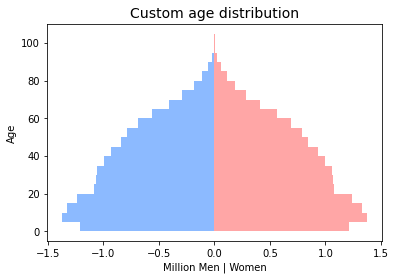

In [7]:
#@title The custom pyramid (rerun this cell if you made changes to the frequencies above!)

#plot_age_pyramid(age_dist=age_dists[country], name=EXAMPLE_PYRAMIDS[j], plot_target=ax)
# build the data for the custom pyramid:
# Declare an empty dict to hold the relevant data:
age_dists['(custom)'] = {}
for age_bin, w in w_custom_distributions.items():
  # Calculate number of women and men
  f = w.value * w_women_prop_custom.value
  m = w.value * (1.0 - w_women_prop_custom.value)
  age_dists['(custom)'][age_bin] = (f, m)
# end for: Adding the Custom pyramid

# Now plot it:
fig, ax = plt.subplots()
plot_age_pyramid(age_dist=age_dists['(custom)'], name="Custom age distribution", plot_target=ax)

In [8]:
#@title Age distribution and population size for each City
#@title Daily meetings in each City
# Note: It would be great to turn most of this box into a function, so
# that it can be re-used in the other dashboards. However, as far as
# VS has been able to find, the widgets have to be created one by one,
# they cannot just be copied. copy.deepcopy() fails, as does pickle


# # # # #  CHANGE THE CODE BELOW THIS LINE  # # # # #
# The widget lists
Ws_city_pyramids = []
Ws_city_popsizes = []
# And a list of those lists, to be filled in below, in order
widget_lists = [Ws_city_pyramids, Ws_city_popsizes]
# Descriptions that will end up in the header row
descs = [
  "City",
  "Age distribution",
  "Population",
]
defaults = [
  ["Brazil", "China", "Italy", "Kenya", "United States of America"],
  [1000] * N_CITIES,
]
# # # # #  CHANGE THE CODE ABOVE THIS LINE  # # # # #

# Create the grid
grid = gwidgets.Grid(N_CITIES+1, len(descs), header_row=True, header_column=True)
# Add the descriptions to each top column
for j, desc in enumerate(descs):
  with grid.output_to(0, j):
    print(desc)
  # end with: choosing the appropriate cell
# end for: adding text to each top cell

for c in range(N_CITIES):
  # Print the name (number) of the City
  with grid.output_to(c+1, 0):
    print(f"#{c}")
  # end with: choosing the appropriate cell

  new_wids = []
  

  # # # # #  CHANGE THE CODE BELOW THIS LINE  # # # # #
  # Create the DropDown for Age Dist Pop Pyramid
  new_wids.append(ipywidgets.Dropdown(options=country_options))
  
  # Create the DropDown for Population Size
  new_wids.append(ipywidgets.Dropdown(
      options=[
        (50,50),
        (100,100),
        (500,500),
        ('1,000',1000),
        ('2,000',2000),
        ('5,000',5000),
        ('10,000',10000),
        ('100,000',100000)
      ],
  ))
  # # # # #  CHANGE THE CODE ABOVE THIS LINE  # # # # #


  for w, wid in enumerate(new_wids):
    # Set the default values
    wid.value = defaults[w][c]
    # Add the widget to its corresponding list
    widget_lists[w].append(wid)
    with grid.output_to(c+1, w+1):
      display(wid)
    # end with: choosing the appropriate cell
  # end for: adding the new widgets for this row (City)
# end for: going over each City to add new widgets

,,
,,
,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

City


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Age distribution


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Population


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(index=24, options=('(custom)', 'Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', …

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(index=3, options=((50, 50), (100, 100), (500, 500), ('1,000', 1000), ('2,000', 2000), ('5,000', 5000)…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(index=37, options=('(custom)', 'Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', …

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(index=3, options=((50, 50), (100, 100), (500, 500), ('1,000', 1000), ('2,000', 2000), ('5,000', 5000)…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(index=92, options=('(custom)', 'Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', …

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(index=3, options=((50, 50), (100, 100), (500, 500), ('1,000', 1000), ('2,000', 2000), ('5,000', 5000)…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(index=97, options=('(custom)', 'Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', …

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(index=3, options=((50, 50), (100, 100), (500, 500), ('1,000', 1000), ('2,000', 2000), ('5,000', 5000)…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(index=191, options=('(custom)', 'Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda',…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dropdown(index=3, options=((50, 50), (100, 100), (500, 500), ('1,000', 1000), ('2,000', 2000), ('5,000', 5000)…

<IPython.core.display.Javascript object>

In [9]:
#@title Daily meetings in each City

# # # # #  CHANGE THE CODE BELOW THIS LINE  # # # # #
# The widget lists
Ws_n_meetings_regular      = []
Ws_n_meetings_high_contact = []
Ws_p_high_contact          = []
# And a list of those lists, to be filled in below, in order
widget_lists = [Ws_n_meetings_regular, Ws_n_meetings_high_contact, Ws_p_high_contact]
# Descriptions that will end up in the header row
descs = [
  "City",
  "Mean number of daily meetings\nfor \"regular\" people",
  "Mean number of daily meetings\nfor \"high-contact\" people",
  "Proportion of people in\nthe high-contact group",
]
defaults = [
  [30] * N_CITIES,
  [500] * N_CITIES,
  [0.10] * N_CITIES,
]
# # # # #  CHANGE THE CODE ABOVE THIS LINE  # # # # #

grid = gwidgets.Grid(N_CITIES+1, len(descs), header_row=True, header_column=True)

# Add the descriptions to each top column
for j, desc in enumerate(descs):
  with grid.output_to(0, j):
    print(desc)
  # end with: choosing the appropriate cell
# end for: adding text to each top cell

for c in range(N_CITIES):
  # Print the name (number) of the City
  with grid.output_to(c+1, 0):
    print(f"#{c}")
  # end with: choosing the appropriate cell

  new_wids = []
  

  # # # # #  CHANGE THE CODE BELOW THIS LINE  # # # # #
  # Create the IntSlider for the daily regular meetings
  new_wids.append(ipywidgets.IntSlider(value=30, min=5, max=500, step=5))
  # Create the IntSlider for the daily high-contact meetings
  new_wids.append(ipywidgets.IntSlider(value=500, min=50, max=2000, step=10))
  # Create the FloatSlider for prop. high-contact
  new_wids.append(ipywidgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01))
  # # # # #  CHANGE THE CODE ABOVE THIS LINE  # # # # #


  for w, wid in enumerate(new_wids):
    # Set the default values
    wid.value = defaults[w][c]
    # Add the widget to its corresponding list
    widget_lists[w].append(wid)
    with grid.output_to(c+1, w+1):
      display(wid)
    # end with: choosing the appropriate cell
  # end for: adding the new widgets for this row (City)
# end for: going over each City to add new widgets

,,,
,,,
,,,
,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

City


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mean number of daily meetings
for "regular" people


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mean number of daily meetings
for "high-contact" people


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Proportion of people in
the high-contact group


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=30, max=500, min=5, step=5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=500, max=2000, min=50, step=10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatSlider(value=0.1, max=1.0, step=0.01)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=30, max=500, min=5, step=5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=500, max=2000, min=50, step=10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatSlider(value=0.1, max=1.0, step=0.01)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=30, max=500, min=5, step=5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=500, max=2000, min=50, step=10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatSlider(value=0.1, max=1.0, step=0.01)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=30, max=500, min=5, step=5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=500, max=2000, min=50, step=10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatSlider(value=0.1, max=1.0, step=0.01)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=30, max=500, min=5, step=5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=500, max=2000, min=50, step=10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatSlider(value=0.1, max=1.0, step=0.01)

<IPython.core.display.Javascript object>

In [10]:
#@title Health pre-conditions and number of people infected a priori in each City

# # # # #  CHANGE THE CODE BELOW THIS LINE  # # # # #
# The widget lists
Ws_n_preconditions_at_birth = []
Ws_n_infected_a_priori      = []
# And a list of those lists, to be filled in below, in order
widget_lists = [Ws_n_preconditions_at_birth, Ws_n_infected_a_priori]
# Descriptions that will end up in the header row
descs = [
  "City",
  "Mean number of existing health\npre-conditions at birth",
  "Number of people infected a priori",
]
defaults = [
  [2] * N_CITIES, # n_preconditions_at_birth
  [5,0,0,0,0],# * N_CITIES, # n_infected_a_priori
]
# # # # #  CHANGE THE CODE ABOVE THIS LINE  # # # # #

# Create the grid
grid = gwidgets.Grid(N_CITIES+1, len(descs), header_row=True, header_column=True)
# Add the descriptions to each top column
for j, desc in enumerate(descs):
  with grid.output_to(0, j):
    print(desc)
  # end with: choosing the appropriate cell
# end for: adding text to each top cell

for c in range(N_CITIES):
  # Print the name (number) of the City
  with grid.output_to(c+1, 0):
    print(f"#{c}")
  # end with: choosing the appropriate cell

  new_wids = []
  

  # # # # #  CHANGE THE CODE BELOW THIS LINE  # # # # #
  # IntSlider for the number of pre-conditions at birth for each City
  new_wids.append(
    ipywidgets.IntSlider(min=0, max=50, step=1)
  )
  new_wids.append(
    ipywidgets.IntText(min=1)
  )
  # # # # #  CHANGE THE CODE ABOVE THIS LINE  # # # # #


  for w, wid in enumerate(new_wids):
    # Set the default values
    wid.value = defaults[w][c]
    # Add the widget to its corresponding list
    widget_lists[w].append(wid)
    with grid.output_to(c+1, w+1):
      display(wid)
    # end with: choosing the appropriate cell
  # end for: adding the new widgets for this row (City)
# end for: going over each City to add new widgets

,,
,,
,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

City


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mean number of existing health
pre-conditions at birth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of people infected a priori


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=2, max=50)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntText(value=5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=2, max=50)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntText(value=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=2, max=50)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntText(value=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=2, max=50)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntText(value=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntSlider(value=2, max=50)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntText(value=0)

<IPython.core.display.Javascript object>

## Inter-City travel connectivity
The 5 cities in the model are presently connected minimalistically as follows:

![City connectivity](https://raw.githubusercontent.com/vsojo/covid19/master/_img/City_connectivity_03.png)

These connections are bi-directional, i.e. travel can happen from 0 to 1, and backwards.

The initial (e.g. zoonotic) infection happens by default at the City #0 only, and may travel from there to the other 4 cities, according to their connectivity and to the migration likelihoods and imposed travel restrictions.

In [11]:
#@title Proportion of citizens that travel to other cities each day
w_p_daily_travels = ipywidgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.05)
display(w_p_daily_travels)

FloatSlider(value=0.05, max=1.0, step=0.01)

In [12]:
#@title Code for the City class [double-click here to show/hide code]
class City:
  def __init__(self, **kwargs):
    # OBLIGATORY PARAMETERS THAT MUST BE SENT UPON CONSTRUCTION
    self._number = kwargs['number'] # Just an index so that we can track this City from others
    self._starting_population = kwargs['population'] # The population is hard set only upon initiation. Afterwards it is calculated as len(self._people)
    self._age_dist = kwargs['age_dist']
    # Daily meetings (regular vs. high-contact Persons)
    self._n_meetings_regular        = kwargs['group_size_regular']
    self._n_meetings_high_contact   = kwargs['group_size_high_contact']
    self._p_high_contact            = kwargs['p_high_contact']
    # Health pre-conditions
    self._n_preconditions_at_birth  = kwargs['n_preconditions_at_birth']
    self._n_infected_a_priori       = kwargs['n_infected_a_priori']
    # Travel
    self._p_daily_travels           = kwargs['p_daily_travels']
    
    # OTHER PARAMETERS #
    # A tracker of what day (iteration) today is, defaulting to 0 upon construction
    self._today = kwargs['today'] if 'today' in kwargs else 0
    self._name = kwargs['name'] if 'name' in kwargs else f"#{self._number}"
    # Connectivity network for travel between cities:
    if 'travel_network' in kwargs:
      self._travel_network = kwargs['travel_network'] 
    else:
      # Set dummy values as simply the next and previous cities:
      self._travel_network = [self._number-1, self._number+1]
      # correct the dummy cities network
      self._travel_network = [c-N_CITIES if c>=N_CITIES else c for c in self._travel_network]
      self._travel_network = [c+N_CITIES if c<0 else c for c in self._travel_network]
    # end: Travel network between this City and others
    
    self._p_migration = kwargs['p_migration'] if 'p_migration' in kwargs else 0.1
    self._in_lockdown_to_foreigners = kwargs['in_lockdown_to_foreigners'] if 'in_lockdown_to_foreigners' in kwargs else False
    self._in_lockdown_to_all = kwargs['in_lockdown_to_all'] if 'in_lockdown_to_all' in kwargs else False
    
    # HOSPITAL DATA
    self._N_HOSP_BEDS_PER_1K = kwargs['N_HOSP_BEDS_PER_1K'] if 'N_HOSP_BEDS_PER_1K' in kwargs else 2.0
    self._N_HOSP_BEDS_ORIGINAL = kwargs['N_HOSP_BEDS_ORIGINAL'] if 'N_HOSP_BEDS_ORIGINAL' in kwargs else math.ceil(self._starting_population * self._N_HOSP_BEDS_PER_1K/1e3)
    self._n_hosp_beds_available = kwargs['n_hosp_beds_available'] if 'n_hosp_beds_available' in kwargs else self._N_HOSP_BEDS_ORIGINAL
    self._n_hosp_beds_in_use = kwargs['n_hosp_beds_in_use'] if 'n_hosp_beds_in_use' in kwargs else 0
    self._n_ventilators_per_100k = kwargs['n_ventilators_per_100k'] if 'n_ventilators_per_100k' in kwargs else 10.0
    self._N_VENTILATORS_ORIGINAL = kwargs['N_VENTILATORS_ORIGINAL'] if 'N_VENTILATORS_ORIGINAL' in kwargs else math.ceil(self._starting_population * self._n_ventilators_per_100k/100e3)
    self._n_ventilators_available = kwargs['n_ventilators_available'] if 'n_ventilators_available' in kwargs else self._N_VENTILATORS_ORIGINAL
    self._n_ventilators_in_use = kwargs['n_ventilators_in_use'] if 'n_ventilators_in_use' in kwargs else 0
    self._n_hosp_beds_available = self._N_HOSP_BEDS_ORIGINAL
    
    # RegEx to change list of attributes into kwargs extraction or default value:
    # SEARCH:- ([\w]+): [\w]+ = (.*) REPLACE:self._\1 = kwargs['\1'] if '\1' in kwargs else \2
    
    # LISTS OF PEOPLE IN THE CITY
    self._people = []
    # Helper lists to deal with meetings and travelling
    self._socials   = []
    self._asocials  = []
    self._incomers  = [] # a list of people that will come into the City at the beginning of each round
    
    # SOCIAL NETWORK
    # A tracker of how many people get infected by each person, per Pathogen
    # the first key is a Pathogen, then a Person infected with that Pathogen
    self._n_infections_given = {pathogen: defaultdict(int) for pathogen in PATHOGENS}
    # And add a Netwok Graph of who infected whom
    # Directed graphs (nx.DiGraph()) make the Plotly plotting messy
    # for some reason,so we need to use undirected:
    self._infection_network = {pathogen: nx.Graph() for pathogen in PATHOGENS}
    
    ##################################################
    # Initialise the infection trackers for the City #
    ##################################################
    # The City contains lists of infected Persons for each infection, in an initially empty defaultdict
    # Whenever a citizen Person gets infected, this default dict is fed. Note that once a Person is
    # in this list, they stay forever in the list as a historical tracker for each infection.

    self._INFECTION_STATUSES = [
        SUSCEPTIBLE     ,
        EXPOSED         ,
        INFECTIOUS      ,
        IMMUNE          ,
        RESUSCEPTIBLE   ,
        ALL_INFECTED    ,
        DAILY_INFECTIONS,
        R_VALUE         ,
        #R_VALUE_RUN_AVG ,
    ]
    # _infection_trackers will have the full list of who is in which
    # category, for each Pathogen, during only the present time (iteration)
    self._infection_trackers = {}
    # And _daily_counts stores the counts for each status, for each Pathogen, for each day (iteration)
    self._infection_counts   = {}
    for status in self._INFECTION_STATUSES:
      self._infection_trackers[status] = {pathogen: []  for pathogen in PATHOGENS}#defaultdict(list)
      self._infection_counts[status]   = {pathogen: [0] for pathogen in PATHOGENS}
    # end for: feeding the status tracker and daily counts dictionaries

    ###########################
    # Population distribution #
    ###########################
    # The age distribution comes in 5-year age bins.
    # Declare an empty list to hold age dists by 1-year bins
    age_dist_by_year = []
    for age_tuple, age_bin in zip(AGE_TUPLES, AGE_BINS):
      for year in range(age_tuple[0], age_tuple[1]+1):
        bin_size = age_tuple[1] - age_tuple[0] + 1
        # Frequencies for F and M, respectively, are in a tuple in the age_dist,
        # so divide both of them by the size of the age_bin
        age_dist_by_year.append( (freq/bin_size for freq in self._age_dist[age_bin]) )
      # end for: feeding the year-by-year age dist
    # end for: going over every age bin
    # Now create a Pandas dataframe
    df = pd.DataFrame(age_dist_by_year)
    # And create cumulative probabilities for women and men,
    # so that the number starts at zero with women and 
    # finishes at 1 with men.
    # This way we can later use a random number to test
    # whether a person is woman/man, and how old
    df['cumsum_F'] = df[F].cumsum()/(df[F].sum()+df[M].sum())
    df['cumsum_M'] = df[M].cumsum()/(df[F].sum()+df[M].sum()) + df['cumsum_F'][MAX_AGE]
    # Make a single list with all the cumulative probabilities.
    # This list will be twice as long as the number of ages,
    # we will deal with that below.
    self._age_FM_cumprobs = list(df['cumsum_F']) + list(df['cumsum_M'])
    del(df, age_dist_by_year) # Delete the data frame
  
    ################################################
    # Create citizens upon origination of the City #
    ################################################
    self.add_new_people(self._starting_population)

    # INFECT A FEW PERSONS IN THE FIRST CITY, JUST TO GET STARTED
    # But first check if the number is positive and not larger than the population
    if self._n_infected_a_priori < 0:
      self._n_infected_a_priori = 0
      print(f"WARNING: Number of Persons infected a priori for City #{self._number} was out of bounds. Changed to {self._n_infected_a_priori}!")
    if self._n_infected_a_priori > 0.99*self.population():
      self._n_infected_a_priori = 0.99*self.population()
      print(f"WARNING: Number of Persons infected a priori for City #{self._number} was out of bounds. Changed to {self._n_infected_a_priori}!")
    # OK, now do infect a few Persons at random
    for i in random.sample(range(self.population()), self._n_infected_a_priori):
      self.add_infected(person=self._people[i], pathogen=PATHOGENS[0], infected_by=None)
    # end for: infecting a few Persons in the City

  ##### end def __init__(): the class constructor #####


  def __str__(self):
    return f"#{self._number}"#f"This is City id:#{id(self)} and it has a population of {self.population()}"
  def __repr__(self):
    return f"#{self._number}"
  
  def __del__(self):
    # log the statistics of this person's death:
    pass#self._current_city.log_death(self)

    
  #########################
  # GETTER/SETTER METHODS #
  #########################
  # Most of these are only getter methdos, because most of these properties should not be changed
  # by force. Instead, use the appropriate functions to change these attributes,
  # e.g. If you want to add/remove people, use the add_new_people() or remove_people() methods,
  # instead of trying to change the _population or _people attributes directly
  def number(self):
    return self._number
  def name(self):
    return self._name
  def people(self):
    return self._people
  def population(self):
    return len(self._people)
  def N_HOSP_BEDS_PER_1K(self):
    return self._N_HOSP_BEDS_PER_1K
  def N_HOSP_BEDS_ORIGINAL(self):
    return self._N_HOSP_BEDS_ORIGINAL
  def n_hosp_beds_available(self):
    return self._n_hosp_beds_available
  def n_hosp_beds_in_use(self):
    return self._n_hosp_beds_in_use
  def n_ventilators_per_100k(self):
    return self._n_ventilators_per_100k
  def N_VENTILATORS_ORIGINAL(self):
    return self._N_VENTILATORS_ORIGINAL
  def n_ventilators_available(self):
    return self._n_ventilators_available
  def n_ventilators_in_use(self):
    return self._n_ventilators_in_use
  def birth_comorbidities_poisson_lambda(self):
    return self._birth_comorbidities_poisson_lambda
  # A few hybrid setter/getter methods
  def group_size_regular(self, new_group_size_regular=None):
    if new_group_size_regular: self._group_size_regular = new_group_size_regular
    return self._group_size_regular
  def p_high_contact(self, new_p_high_contact=None):
    if new_p_high_contact: self._p_high_contact = new_p_high_contact
    return self._p_high_contact
  def group_size_high_contact(self, new_group_size_high_contact=None):
    if new_group_size_high_contact: self._group_size_high_contact = new_group_size_high_contact
    return self._group_size_high_contact
  def p_migration(self, new__p_migration=None):
    if new_p_migration: self._p_migration = new_p_migration
    return self._p_migration
  def travel_network(self, set__travel_network=None):
    if set__travel_network: self._travel_network = set__travel_network
    return self._travel_network
  def in_lockdown_to_all(self, set__in_lockdown_to_all=None):
    if set__in_lockdown_to_all in [True, False]:
      self._in_lockdown_to_all = set__in_lockdown_to_all
    return self._in_lockdown_to_all
  def in_lockdown_to_foreigners(self, set__in_lockdown_to_foreigners=None):
    if set__in_lockdown_to_foreigners in [True, False]:
      self._in_lockdown_to_foreigners = set__in_lockdown_to_foreigners
    return self._in_lockdown_to_foreigners

  def infection_trackers(self, status=None, pathogen=None):
    """
    Returns the lists of Persons per Pathogen and per Infection status.
    """
    if status:
      if pathogen:
        # This is the most specific and probably the most common case:
        # we want to know who is in a certain status for a given Pathogen
        return self._infection_trackers[status][pathogen]
      else:
        # No Pathogen specified, return the full dictionary with lists of Persons who have this status for all Pathogens
        return self._infection_trackers[status]
      # end if: status required, but was a Pathogen specified?
    else: # No status required, so we want to know all possible statuses, either for one Pathogen, or for all
      if pathogen:
        # User wants to have the list of Persons in all possible statuses for this Pathogen
        return {status: self._infection_trackers[status][pathogen] for status in self._INFECTION_STATUSES}
      else: # Nothing specified, so just return the whole thing
        return self._infection_trackers
      # end if: No status specified, but was a Pathogen specified?
    # end if: was a status specified?
  # end def: infection_trackers()

  def infection_counts(self, status=None, pathogen=None):
    """
    Returns list(s) with the historical numbers of Persons per infection status per Pathogen.
    """
    if status:
      if pathogen:
        # This is the most specific and probably the most common case:
        # we want to know who is in a certain status for a given Pathogen
        return self._infection_counts[status][pathogen]
      else:
        # No Pathogen specified, return the full dictionary with historical counts of Persons who have this status for all Pathogens
        return self._infection_counts[status]
      # end if: status required, but was a Pathogen specified?
    else: # No status required, so we want to know all possible statuses, either for one Pathogen, or for all
      if pathogen:
        # User wants to have the counts of Persons in all possible statuses for this Pathogen
        return {status: self._infection_counts[status][pathogen] for status in self._INFECTION_STATUSES}
      else: # Nothing specified, so just return the whole thing
        return self._infection_counts
      # end if: No status specified, but was a Pathogen specified?
    # end if: was a status specified?
  # end def: infection_counts()

  ### END GETTER/SETTER METHODS ###


  #######################################
  #  HEALTH STATUS/SYMPTOM PROGRESSION  #
  #######################################
  def assign_hospital_bed(self, person):
    """
    ToDo: for now this is just a dummy that always returns True.
    The plan is to have a function that checks the number of available
    beds and decreases it by one and returns true if enough, or returns
    False if there aren't any left.
    """
    return True
  # end def: assign_hospital_bed()

  def assign_icu(self, person):
    """
    ToDo: for now this is just a dummy that always returns True.
    The plan is to have a function that checks the number of available
    ICUs and decreases it by one and returns true if enough, or returns
    False if there aren't any left.
    """
    return True
  # end def: assign_icu()


  ####################
  #  SOCIAL NETWORK  #
  ####################
  def n_infections_given(self, pathogen=None):
    if pathogen:
      return self._n_infections_given[pathogen]
    else:
      return self._n_infections_given
  def infection_network(self, pathogen=None):
    if pathogen:
      return self._infection_network[pathogen]
    else:
      return self._infection_network
  # END: GETTER/SETTER METHODS FOR THE CITY CLASS


  ###################################
  #  ADDING NEW PEOPLE TO THE CITY  #
  ###################################
  def add_new_people(self, n_people):
    """
    Adds new Persons to the City, using random
    values for age, number of daily meetings,
    and whether the person is high-contact or not.
    """
    ### AGE DISTRIBUTION ###
    # Create a list of random uniform numbers in [0..1] for as many people as desired
    rands = np.random.random(n_people)
    # Use numpy to find the ages to which these numbers belong,
    # given the population pyramid of this City. That is,
    # turn the random numbers into ages, according
    # to the cumulative probabilities calculated
    # from the age distribution
    pseudo_ages = np.digitize(rands, self._age_FM_cumprobs)
    # Note that, because we used cumulative probabilities,
    # the ages aren't really ages yet!
    # Females are at the beginning, from 0 to 104, so that is correct,
    # but Males go from 105 to 209, so that needs to be corrected.
    # We do that below upon creation of each Person
    
    ### NUMBER OF PRE-CONDITIONS ###
    rand_n_preconditions = poisson.rvs(self._n_preconditions_at_birth, size=n_people)
    
    for i in range(n_people):
      ### AGE & SEX ###
      age = pseudo_ages[i]
      if age > MAX_AGE:
        # Please see above. Males go from 105 to 209, so we need to subtract 104.
        age -= (MAX_AGE + 1)
        sex = M
        #men.append(age)
      else:
        sex = F
      # end if: is this a Male or a Female?

      ### NUMBER OF DAILY CONTACTS ###
      # Is this person high-contact?
      if get_rand() < self._p_high_contact:
        n_daily_contacts = poisson.rvs(self._n_meetings_high_contact)
      else: # It's a "regular" person
        n_daily_contacts = poisson.rvs(self._n_meetings_regular)
      # end if: is this person high contact?
      
      ### CREATE A NEW PERSON ###
      p = Person(home_city=self, age=age, sex=sex, n_preconditions=rand_n_preconditions[i], n_daily_contacts=n_daily_contacts)
      # Add them to the list of people in this City
      self._people.append(p)

      # and for every Pathogen we know of, add them to the list of SUSCEPTIBLE people
      for pathogen in PATHOGENS:
        self._infection_trackers[SUSCEPTIBLE][pathogen].append(p)
        self._infection_counts[SUSCEPTIBLE][pathogen][-1] += 1
    # end for: adding new people one by one
  # end def add_new_people(): method to create people at the beginning of the run

  def remove_people(self, list_of_people):
    """Handles deaths (and should eventually handle emigration)"""
    if isinstance(list_of_people, Person):
      # Received a single Person, so turn it into a list
      list_of_people = [list_of_people]
    for person in list_of_people:
      # remove this person from the list of people in this city
      self._people.remove(person)
      # WARNING: if the person is still alive, make sure it is informed wherever
      # this function was called that it no longer lives here!
  # end def remove_people


  ############
  #  TRAVEL  #
  ############
  def receive_traveller(self, person, verbose=True):
    """
    Receives people from other cities during a round, and puts them on-hold
    into a list. At the beginning of each round, the list is checked to see if
    there are any Persons waiting to enter this City.
    If the City is in lockdown, only citizens are allowed in, all others are
    bounced by returning False.
    If the City is in full lockdown, everyone is bounced by returning False,
    including citizens.
    Those allowed in are put into a list that gets processed at the beginning
    of an iteration.
    """
    person.log(f"Attempting to enter City {self} from {person.current_city()}.")
    if not isinstance(person, Person):
      raise TypeError("The traveller must be a Person. Instead, the object received is of type", type(person))
    # Is this City in lockdown? Full lockdown or only locked down to foreigners?
    if self._in_lockdown_to_all:
      if verbose: print("WARNING: Destination city is in full lockdown and even citizens are not allowed in! Sorry, we could not welcome this Person.")
      return False
    elif self._in_lockdown_to_foreigners and person.home_city()!=self:
      if verbose: print("WARNING: Destination city is in lockdown and this person is not a citizen! Sorry, we could not welcome this Person.")
      return False
    else:
      # it's fine, this person is allowed in
      self._incomers.append(person)
      person.log(f"\tSUCCESS!\n")
      return True
  # end def receive_traveller()

  def _process_immigrations(self):
    """
    Processes all the immigrations, normally at the beginning of a day.
    """
    for person in self._incomers:
      person.log(f"Being processed at immigration of City {self._number}.\n")
      # Add the Person to the City's people
      self._people.append(person)
      # Change the current City for this Person
      person.current_city(self)
      person.log(f"My City has been changed to {person.current_city()}, and I am presently in City {self}.\n")
      for pathogen in PATHOGENS:
        if pathogen in person.infections():
          status = person.infections(pathogen).status()
        else: # the person is susceptible to this Pathogen, so remove from that tracker too
          status = SUSCEPTIBLE
        # end if: has this person encountered this Pathogen? Otherwise they are SUSCEPTIBLE
        # Add the infection status of the Person to the relevant tracker
        self._infection_trackers[status][pathogen].append(person)
        self._infection_counts[status][pathogen][-1] += 1
      # end for: processing all Pathogens
    # end for: processing each incoming Person
  # end def: process immmigrations

  def do_emigration(self):
    """
    Sends people to other Cities. This function needs to be called outside the
    normal day iteration, once all Cities have finished their days. Otherwise -- 
    i.e. if called within the iteration code -- the later Cities will be
    receiving people from the previous Cities during a day, as opposed to at the
    beginning of the day. This is because the end of the day for a City is the
    beginning of the day for the next one, due to the way we are doing the for
    loops (for city in CITIES), i.e. one City is handled after the other.
    So, in conclusion, call this function after all the cities have done their 
    day.
    """
    # Get a random list of people to leave the City
    emigrant_idx = random.sample(range(self.population()), round(self.population()*self._p_daily_travels))
    emigrant_idx.sort(reverse=True)
    q = 0 # the index of the city to which the person will travel. i.e. not City #0 itself, but the first City in the list of connected cities
    for i in emigrant_idx:
      person = self._people[i]
      # Remove the person from this City's list of people
      self._people.remove(person)
      # And update the trackers
      for pathogen in PATHOGENS:
        if pathogen in person.infections():
          status = person.infections(pathogen).status()
        else: # the person is susceptible to this Pathogen, so remove from that tracker too
          status = SUSCEPTIBLE
        # end if: has this person encountered this Pathogen? Otherwise they are SUSCEPTIBLE

        # Remove the infection status of the Person from the relevant tracker
        self._infection_trackers[status][pathogen].remove(person)
        #self._infection_trackers[status][pathogen].remove(person)
        self._infection_counts[status][pathogen][-1] -= 1
      # end for: removing the person from the trackers of all Pathogens for the present City
      
      # Choose a City from this City's network, and send the Person there
      #print(f"Cities: {CITIES}")
      #print(f"q: {q}")
      CITIES[self._travel_network[q]].receive_traveller(person)

      # Increase the pointer of chosen City to travel to so that the next person
      # goes to the next City in the list of connected cities.
      # Note: This will favour the first City in the list, so, instead of using
      # this indexing method, we could just random.choice() from the list of
      # connected cities, but that may be slower. Would need to test.
      q += 1
      # But if we're at the end of the possible cities, just circle back to the first one
      if q >= len(self._travel_network): q = 0
    # end for: processing all the outgoing travellers
  # end def: _do_emigration()

  ###############
  #  HOSPITALS  #
  ###############
  def release_hospital_bed(self):
    """Releases a hospital bed that a Person had assigned."""
    self._n_hosp_beds_available += 1
  # end def: release a hospital bed
  def release_ventilator(self):
    """Releases a hospital bed that a Person had assigned."""
    self._n_ventilators_available += 1
  # end def: release a hospital bed
  

  ################
  #  INFECTIONS  #
  ################
  def add_infected(self, person, pathogen, infected_by=None):
    """Add a Person to the list of Persons infected with a given Pathogen."""
    # Infect the Person
    person.get_infected(pathogen, infected_by, self._today)
    # Add the person to the list of to DAILY_INFECTIONS and of ALL infections ever
    for status in [ALL_INFECTED, DAILY_INFECTIONS]:
      self._infection_trackers[status][pathogen].append(person)
    # Update the trackers for SUSCEPTIBLE and EXPOSED
    self.person_status_changed(person, pathogen, SUSCEPTIBLE, EXPOSED)
    # And the counters also, in case this infection happened at time Zero,
    # i.e. outside the iteration loop where these values are normally updated
    if self._today == 0:
      self._infection_counts[ALL_INFECTED][pathogen][-1]     += 1
      self._infection_counts[SUSCEPTIBLE][pathogen][-1]      -= 1
      self._infection_counts[EXPOSED][pathogen][-1]          += 1
      self._infection_counts[DAILY_INFECTIONS][pathogen][-1] += 1
      # Track the infection given by the infection giver
      self._n_infections_given[pathogen][infected_by] += 1
    # is this time zero?
    
    ###################################
    # SOCIAL NETWORKING OF INFECTIONS #
    ###################################
    # Start the counter of how many infections this person has given to other Persons
    self._n_infections_given[pathogen][person] = 0
    # add the person as a NODE to the network of infected/infectious people
    self._infection_network[pathogen].add_node(person)
    # and add an EDGE if we know who infected them
    if infected_by:
      self._infection_network[pathogen].add_edge(infected_by, person)
  # end def: add_infected()

  def person_status_changed(self, person, pathogen, status_from, status_to):
    """Manages changing the Infection status of a Person, especially with regards to the count trackers"""
    # Remove the Person from the tracker they were in
    try:
      self._infection_trackers[status_from][pathogen].remove(person)
    except ValueError:
      raise ValueError(
          f"We are in City {self}.\n"+
          f"This person's Home City is {person.home_city()}.\n"+
          f"Their current city is {person.current_city()}.\n"+
          f"Their health status is {person.infections()[pathogen].status()}.\n"+
          f"And we were trying to change it from {status_from} to {status_to}"
      )
    # And add them to the new one:
    self._infection_trackers[status_to][pathogen].append(person)
  # end def: person_status_changed()


  ############################
  #  MEETING HANDLER METHOD  #
  ############################
  # **ToDo** currently this algorithm keeps repeating meetings until people have
  # done all their preferred daily meetings. This is not entirely realistic. If
  # a considerable amount of people change their behaviour and do not go out,
  # it is unlikely that others would meet as many different people as they
  # would have normally. In this case, it is possible that people who have many
  # meetings will just end up meeting each other repeatedly at he end. This may
  # be acceptable, but it is worth considering
  def _do_a_meeting(self, meeting_size, is_superspreader=False):
    """Handles a meeting between a specified number of people"""
    # Only go ahead if there are enough people willing to do this meeting
    if len(self._socials) < meeting_size:
      return False

    # Shuffle the list of socials, i.e. those Persons with remaining meetings
    random.shuffle(self._socials)
    # A list of people who have done all their meetings for this iteration. Starts empty.
    self._asocials = []
    # Go over each group of MEETING_SIZE Persons and handle their meeting
    for i in range(len(self._socials)//meeting_size):
      '''
      NOTE ON SUPER-SPREADER EVENTS:
      If left unchecked, this code goes over the entire population and forces
      them all to meet in meetings of meeting_size.
      This works fine for regular meetings, but super-spreaders should be
      a one-off thing, they should not happen for everybody.
      The simplest -- if least elegant -- way to solve this is to just break
      out at this loop at the end if going over a super-spreader day. It's not
      elegant, but it works, so that's what we're doing for the time being.
      '''
      # Build up a group for MEETING_SIZE people
      meeting_group = []
      for j in range(meeting_size):
        meeting_group.append(self._socials[i*meeting_size+j])
      # end for: building the meeting_group
      #print(meeting_group)

      # GET ALL THE PATHOGENS ACTIVELY CARRIED BY THE PEOPLE IN THIS MEETING GROUP:
      active_pathogens   = defaultdict(int)
      infectious_persons = defaultdict(list)
      for person in meeting_group:
        # SUPER SPREADER EVENT #
        if is_superspreader:
          person.was_at_superspreader(self._today)
        # end if: Adding whether the person was at a superspreader today

        for pathogen, infection in person.infections().items():
          # If the Infection is still contagious, increase
          # the counter for its Pathogen (these many people
          # have the Pathogen in this meeting)
          if infection.status() == INFECTIOUS:
            active_pathogens[pathogen] += 1
            infectious_persons[pathogen].append(person)
        # end for: looking for infectious people
      # end for: getting all the Pathogens carried by Persons in this meeting

      # Recode the count of each Pathogen's frequency into a probability given
      # by 1 - that Pathogen's infectivity to the power of how many people have it.
      # This can be used later to determine whether a non-infected person in this group gets infected.
      for pathogen, count in active_pathogens.items():
          active_pathogens[pathogen] = 1 - (1-pathogen.infectivity())**count
      # end for: recoding Pathogens to a power of infectivity

      #print(PATHOGENS)

      # MEETING:
      #meeters_txt = ""
      for person in meeting_group:
        # HANDLING INFECTION
        #meeters_txt += str(person) + '\t'
        for pathogen, prob in active_pathogens.items():
          if not pathogen in person.infections():
            # this person has never had this Pathogen. May get infected with it
            if get_rand() < prob:
              ######################
              # INFECTION HAPPENS! #
              ######################
              # Choose one Person at random from the group of infectious people to get infected from
              infection_giver = random.choice(infectious_persons[pathogen])
              # Infect the new Person
              self.add_infected(person, pathogen, infected_by=infection_giver)
              # And track the infection given in the giver
              infection_giver.infections(pathogen).give_infection_to(person)
              #print(f"\n{50*'*'}\n{person}\nhas been INFECTED by\n{infection_giver}!\n{50*'*'}\n")
            # end if: TODO
          # end if: TODO
        # end for: TODO

        # Decrease the counter of meetings remaining
        person.decrease_meetings(meeting_size - 1)
        # Note that the counter can go below 0. That's ok, we just assume the person
        # ended up meeting a few more people than desired (e.g. it was especially busy
        # at a place they visited today)

        # check if any of the Persons have done all their meetings
        if person.remaining_meetings() <= 0:
          self._asocials.append(person) # this is better than removing from socials here.
          # If we removed from socials here, we'd change the size of socials and mess
          # up the indexing that we're using to handle the meetings, so it's best to
          # add Persons who completed their meetings to a list and remove them at the
          # end of this meeting round.
        # end if: adding Person to a list of Persons who have finished their meetings
      # end for: handling the meetings between all members of this meeting group
      #print(meeters_txt)

      # BREAK OUT IF IT'S A SUPERSPREADER DAY.
      # i.e. only run the superspreader event once
      if is_superspreader:
        break
    # end for: meeting of socials in groups of MEETING_SIZE size

    # If there are any persons that have finished their desired meetings, remove them
    for person in self._asocials:
      # Remove this Person from the list of socials in this iteration,
      # since they have done all their meetings.
      # This is better than removing them immediately above, because that would change the
      # list size of socials during the iteration above, which would mess everything up.
      self._socials.remove(person)
    # end for: removing all Persons who have completed their meetings.
    return True
  # end def: do_a_meeting()


  ########################
  #                      #
  #  DAY ITERATION CODE  #
  #                      #
  ########################
  def run_iteration(self, do_super_spreader=False):
    """Runs an iteration (a 'day') for this City"""
    # Increase the day counter
    self._today += 1

    ######################
    # DAY INITIALISATION #
    ######################
    # Receive all the immigrating travellers
    self._process_immigrations()
    # Now clear the tracker of immigration
    self._incomers  = []

    # Start the counter of infections for this day at zero
    for pathogen in PATHOGENS:
      # Clear the list of daily infections at the beginning of an iteration
      self._infection_trackers[DAILY_INFECTIONS][pathogen] = []
      for status in self._INFECTION_STATUSES:
        self._infection_counts[status][pathogen].append(len(self._infection_trackers[status][pathogen]))
      # end for:
    # end for:

    # Start the day for each Person in the City
    for person in self._people:
      person.log(f"\n\nToday is day {self._today}\n")
      person.start_day()

    # Initialise the list of people that will be meeting others
    # to the full list of people in the City
    self._socials = self._people.copy()
    
    ###########################
    #  SUPER-SPREADER EVENTS  #
    ###########################
    if do_super_spreader:
      self._do_a_meeting(w_n_people_superspreader_events.value, is_superspreader=True)

    ############################
    #  REGULAR MEETING EVENTS  #
    ############################
    # The meeting sizes for normal events
    MEETING_SIZE = w_meeting_size.value # 2 by default, so 1-to-1 meetings
    # Go over the group of people who still want to have regular (e.g. 1-to-1) meetings
    while len(self._socials) >= MEETING_SIZE:      
      self._do_a_meeting(MEETING_SIZE)
    # end while

    # UPDATE THE COUNTERS OF ONGOING AND PREVIOUS INFECTIONS FOR EACH PATHOGEN
    for status in self._INFECTION_STATUSES:
      for pathogen in PATHOGENS:
        self._infection_counts[status][pathogen][-1] = len(self._infection_trackers[status][pathogen])
    # end for
    
    #############
    #  R-VALUE  #
    #############
    # The R value is calculated using as the number of infections
    # given by any person in the INFECTIOUS category. This may include
    # infections given in previous rounds. That's fine.
    for pathogen in PATHOGENS:
      all_infections_given = []
      for person in self._infection_trackers[INFECTIOUS][pathogen]:
        if person.infections(pathogen).days_since_acquired() == (w_days_until_contagious.value + w_duration_of_contagiousness.value):
          all_infections_given.append(len(person.infections()[pathogen].infected_persons()))
      try:
        self._infection_counts[R_VALUE][pathogen][-1] = sum(all_infections_given)/len(all_infections_given)
      except ZeroDivisionError:
        self._infection_counts[R_VALUE][pathogen][-1] = 0
  # end def: run_iteration()
# END CLASS CITY

# The **Pathogen** class: epidemiological factors
This contains general epidemiological factors of a disease-causing transmissible `Pathogen` -- such as a virus -- and its behaviour in an infected `Person`, chiefly:

Property                          |Description
----------------------------------|----------------------------------
```infectivity``` |What proportion of contacts results in an effective transmission of the `Pathogen`.
```p_symptomatic``` |What proportion of carriers develop symptoms.
```days_until_symptoms``` |How many days until infected person ```starts showing symptoms, in case they do.
```days_symptom_duration``` |How many days do symptoms last, if person is showing them and recovers.
```days_until_contagious``` |Once a person is infected, how many days until they become contagious to others.
```days_until_not_contagious``` |How many days until an infected person stops being contagious to others.
```days_until_resusceptible``` |Once a Person recovers from the infection, how many days until they become susceptible again.


In [13]:
#@title Properties of the `Pathogen` `Infection` (epidemiological factors)

print("Proportion of contacts that result in infection")
w_infectivity = ipywidgets.FloatSlider(value=0.03, min=0.01, max=1.0, step=0.01)
display(w_infectivity)

print("Days until contagious")
w_days_until_contagious = ipywidgets.IntSlider(value=4, min=1, max=25)
display(w_days_until_contagious)

print("How many days contagiousness lasts")
w_duration_of_contagiousness = ipywidgets.IntSlider(value=4, min=1, max=60)
display(w_duration_of_contagiousness)

print("Has vaccine")
w_has_vaccine = ipywidgets.Checkbox(value=False, indent=False)
display(w_has_vaccine)

print("Days until susceptible again after vaccination or infection")
print("(-1 means protection is for life)")
w_days_until_resusceptible = ipywidgets.IntSlider(value=-1, min=-1, max=200)
display(w_days_until_resusceptible)

Proportion of contacts that result in infection


FloatSlider(value=0.03, max=1.0, min=0.01, step=0.01)

Days until contagious


IntSlider(value=4, max=25, min=1)

How many days contagiousness lasts


IntSlider(value=4, max=60, min=1)

Has vaccine


Checkbox(value=False, indent=False)

Days until susceptible again after vaccination or infection
(-1 means protection is for life)


IntSlider(value=-1, max=200, min=-1)

## Progression of symptoms
\[ **IMPORTANT:** Please note that symptom progression is not yet fully implemented, so changing the parameters in the following section will have no effect \]

Symptom progression upon infection works as follows:
+ `HEALTHY` people who acquire an `Infection` can either develop symptoms or not at all.
+ If they do, they are assumed to first get `MILD` symptoms. Since this is a simple transition, we use a single probability below.
+ However, people who are in the intermediate statuses (MILD, UNWELL, or SEVERE) have three options. They can either recover to a better state, stay in the state they are in, or deteriorate into a worse state. For this reason, we provide a two-value slider, explained in further detail below.

The two-value sliders for the intermediate health statuses work as follows:

![City connectivity](https://raw.githubusercontent.com/vsojo/covid19/master/_img/Health_progression_double_sliders.png)

A uniform random number is picked at every iteration (day) for each `Person` in an intermediate health state. In the example in the picture, the random number is `0.16` so, given the parameters selected, the Person's health improves. If the random value had been greater than `0.8`, the Person's health would have worsened. Otherwise (`rand` between `0.2` and `0.8`), they would simply stay as they are for this day.

In [14]:
#@title Values for symptom progression
#######################
# SYMPTOM PROGRESSION #
#######################

### TRANSITION PROBABILITIES BETWEEN SYMPTOM STATUSES ###
Ws_p_symptom_transitions = {}

SYMPTOMS = { # For progression of symptoms
  HEALTHY : "Probability of becoming symptomatic if infected, i.e.\n"
            +"of transitioning from HEALTHY to MILD",
  MILD    : "\nDaily cumulative probabilities of recovering from MILD to HEALTHY (left grey bar),\n"
            +"staying with MILD symptoms (centre blue), or deteriorating to UNWELL (right grey bar)",
  UNWELL  : "\nDaily cumulative probabilities of recovering from UNWELL to MILD (left grey bar), staying\n"
            +"UNWELL (centre blue), or deteriorating to SEVERE (thus needing a hospital bed, right bar)",
  SEVERE  : "\nDaily cumulative probabilities of recovering from SEVERE to UNWELL (i.e. being discharged\n"
            +"from hospital, left grey bar), staying SEVERE (in hospital bed, blue centre), or\n"
            +"deteriorating to CRITICAL (thus requiring an ICU, right grey bar)", 
  CRITICAL: "\nDaily probability of recovering from CRITICAL to SEVERE (i.e.\nleaving the ICU for a regular hospital bed)",
}

Ws_p_symptoms = {}
for symptom, message in SYMPTOMS.items():
  print(message)
  if symptom == HEALTHY:
    # HEALTHY infected people can either develop symptoms or not, so a simple slider:
    wid = ipywidgets.FloatSlider(value=0.5, min=0.01, max=1.0, step=0.01)
  elif symptom == CRITICAL:
    # CRITICAL people can either stay CRITICAL or recover to SEVERE, so a simple slider
    wid = ipywidgets.FloatSlider(value=0.2, min=0.01, max=1.0, step=0.01)
  else:
    # People in the intermediate states MILD, UNWELL, or SEVERE, can either
    # progress to a worse state, or recover to the previous one, so we use
    # a two-value slider
    wid = ipywidgets.FloatRangeSlider(
      value=[0.2, 0.8], # DEFAULT VALUES HERE
      min=0.01, max=0.99, step=0.01,
      continuous_update=False,
      #orientation='horizontal',
      #readout=True,
    )
  # end if: handling special cases of symptoms

  Ws_p_symptoms[symptom] = wid
  display(wid)
# end for: creating the symptom-transition probability sliders

print("Days until symptomatic (in case symptoms develop)")
w_days_until_symptoms = ipywidgets.IntSlider(value=5, min=1, max=25)
display(w_days_until_symptoms)


Probability of becoming symptomatic if infected, i.e.
of transitioning from HEALTHY to MILD


FloatSlider(value=0.5, max=1.0, min=0.01, step=0.01)


Daily cumulative probabilities of recovering from MILD to HEALTHY (left grey bar),
staying with MILD symptoms (centre blue), or deteriorating to UNWELL (right grey bar)


FloatRangeSlider(value=(0.2, 0.8), continuous_update=False, max=0.99, min=0.01, step=0.01)


Daily cumulative probabilities of recovering from UNWELL to MILD (left grey bar), staying
UNWELL (centre blue), or deteriorating to SEVERE (thus needing a hospital bed, right bar)


FloatRangeSlider(value=(0.2, 0.8), continuous_update=False, max=0.99, min=0.01, step=0.01)


Daily cumulative probabilities of recovering from SEVERE to UNWELL (i.e. being discharged
from hospital, left grey bar), staying SEVERE (in hospital bed, blue centre), or
deteriorating to CRITICAL (thus requiring an ICU, right grey bar)


FloatRangeSlider(value=(0.2, 0.8), continuous_update=False, max=0.99, min=0.01, step=0.01)


Daily probability of recovering from CRITICAL to SEVERE (i.e.
leaving the ICU for a regular hospital bed)


FloatSlider(value=0.2, max=1.0, min=0.01, step=0.01)

Days until symptomatic (in case symptoms develop)


IntSlider(value=5, max=25, min=1)

In [15]:
#@title Code for the Pathogen class [double click here to show/hide code]
class Pathogen:
  """Contains all epidemiological factors of a Pathogen (such as a virus)."""

  # CONSTRUCTOR #
  def __init__(self, **kwargs):
    self._name = kwargs['name'] if 'name' in kwargs else "SARS-CoV-2/Covid-19"
    # Customisable parameters extracted from the dashboard above
    ##################
    # INFECTIOUSNESS #
    ##################
    self._infectivity = kwargs['infectivity'] if 'infectivity' in kwargs else w_infectivity.value
    self._days_until_contagious = kwargs['days_until_contagious'] if 'days_until_contagious' in kwargs else w_days_until_contagious.value
    self._days_until_not_contagious = self._days_until_contagious + w_duration_of_contagiousness.value + 1
    self._days_until_resusceptible = kwargs['days_until_resusceptible'] if 'days_until_resusceptible' in kwargs else w_days_until_resusceptible.value
    # Check that the chosen parameters make sense
    if self._days_until_resusceptible > 0 and self._days_until_resusceptible < self._days_until_not_contagious:
      raise ValueError("The number of days until susceptible again have to be more than the time it takes to stop being contagious!")
    
    ############
    # SYMPTOMS #
    ############
    self._days_until_symptoms = kwargs['days_until_symptoms'] if 'days_until_symptoms' in kwargs else w_days_until_symptoms.value
    
    self._p_symptom_progression = {}
    for symptom in SYMPTOMS.keys():
      val = Ws_p_symptoms[symptom].value
      if symptom == HEALTHY:
        self._p_symptomatic = val
      elif symptom in [MILD, UNWELL, SEVERE, CRITICAL]:
        self._p_symptom_progression[symptom] = val
      # end if: 
    # end for: feeding all the probabilities of progressing between symptoms
    
    ###########
    # VACCINE #
    ########### 
    self._has_vaccine = False

  # end def __init__: the CONSTRUCTOR of the class

  def __str__(self):
    return f"This is the {self._name} Pathogen"
  # end def __str__: the string processor of the class
  
  def __repr__(self):
    return f"{self._name}"
  # end def __str__: the string processor of the class
  
  ###########################
  #  GETTER/SETTER METHODS  #
  ###########################
  def name(self):
    return self._name
  def infectivity(self, set__infectivity=None):
    if set__infectivity: self._infectivity(set__infectivity)
    return self._infectivity
  def days_until_contagious(self):
    return self._days_until_contagious
  def days_until_not_contagious(self):
    return self._days_until_not_contagious
  def days_until_resusceptible(self):
    return self._days_until_resusceptible
  # SYMPTOMS #
  def days_until_symptoms(self):
    return self._days_until_symptoms
  def p_symptomatic(self):
    return self._p_symptomatic
  def p_symptom_progression(self, health_status=None):
    if health_status == None:
      return self._p_symptom_progression
    else:
      return self._p_symptom_progression[health_status]
  # VACCINE #
  def has_vaccine(self, set__has_vaccine=None):
    if set__has_vaccine: self._has_vaccine(set__has_vaccine)
    return self._has_vaccine
  # END GETTER/SETTER METHODS

  ########################################
  #  OTHER METHODS OF THE PATHOGEN CLASS  #
  ########################################
  def add_vaccine(self, protection_days=-1):
    # -1 means protection is forever
    self._has_vaccine = True
  # end def add_vaccine
# end class Pathogen

# The **Infection** class
A `Person` can have an **`Infection`**. This is different from the `Pathogen` in that `Pathogen` represents the biological pathogen itself, whereas `Infection` represents a case of that pathogen as acquired by a `Person`. It is therefore of most use to track the progress of the Pathogen in the Person, particularly in terms of infectiousness.

## Properties of an Infection (_attributes_)
* `pathogen`: which Pathogen (e.g. "SARS-CoV-2") this infection involves.
+ `days since infection`: How many days since the infection was acquired.
+ `status`: the infectiousness status. Can be
  * `SUSCEPTIBLE`.
  + `EXPOSED` (carries the virus, but is not yet infectious).
  + `INFECTIOUS`.
  + `IMMUNE` (equivalent to "recovered" in a typical SEIR model).
  + `RESUSCEPTIBLE` (optional, used if immunity is lost after some time, but not entirely).

## Actions of an Infection (_methods_)
* `add_day()`: adds a day to a counter, so that any necessary changes to immunity status can be effected by the Person that has this infection and tracked by the City where the Person resides.

In [16]:
#@title Code for the Infection class [double-click here to show/hide code]
class Infection:
  """
  Can be had by a Person.
  Needs an object of class Pathogen as argument.
  The main difference between Pathogen and Infection objects
  is that a Pathogen is a generic independent entity with epidemiological
  and biological information, such as "Influenza" or "SARS-CoV-2",
  whereas an Infection is a case of such a Pathogen in a Person,
  with details such as when it was acquired, whether the Person is
  contagious for that Pathogen, and so on.
  """
  def __init__(self, **kwargs):
    #########################
    #  REQUIRED PARAMETERS  #
    #########################
    # These are needed upon initialisation.
    # Check if all required parameters were provided:
    required_params = {
       'pathogen'        : "An object of class Pathogen"
      ,'infected_by'    : "An object of class Person, who passed the Pathogen to this Person."
      ,'infection_city' : "The City in which the infection occurred."
      ,'infection_day'  : "The iteration (day) on which the infection occurred."
    }
    if not all([param in kwargs for param in required_params]):
      joiner = "\n\t- "
      raise AttributeError("This Infection needs to receive the following arguments upon creation:\n"
        + joiner + joiner.join(required_params))
    # Initialise the required parameters
    self._pathogen         = kwargs['pathogen']
    self._infected_by     = kwargs['infected_by']
    self._infection_city  = kwargs['infection_city']
    self._infection_day   = kwargs['infection_day']
    
    #########################
    #  OPTIONAL PARAMETERS  #
    #########################
    # The contagiousness status of this Infection. Defaults to EXPOSED, but
    # can be: SUSCEPTIBLE, EXPOSED, INFECTIOUS, IMMUNE (same as "recovered" in SEIR), LATENT ...
    # or RESUSCEPTIBLE (in case reinfection is possible, but with lower susceptibility, otherwise just use SUSCEPTIBLE)
    self._status = kwargs['status'] if 'status' in kwargs else EXPOSED
    # Days since this Pathogen was acquired. Status can change as a result of this
    self._days_since_acquired = kwargs['days_since_acquired'] if 'days_since_acquired' in kwargs else 0
    # List of Persons that this Infection's Person has gone on to infect. Empty by default
    self._infected_persons = kwargs['infected_persons'] if 'infected_persons' in kwargs else []
    # Symptoms for this Infection. Can be ASYMPTOMATIC, MILD, or SEVERE
    self._symptoms = kwargs['symptoms'] if 'symptoms' in kwargs else ASYMPTOMATIC
  # end def: __init__ # Constructor for class Infection

  ###########################
  #  GETTER/SETTER METHODS  #
  ###########################
  def pathogen(self):
    return self._pathogen
  def infected_by(self):
    return self._infected_by
  def infection_city(self):
    return self._infection_city
  def infection_day(self):
    return self._infection_day
  def days_since_acquired(self):
    return self._days_since_acquired
  def status(self, set__status=None):
    if set__status: self._status = set__status
    return self._status
  def infected_persons(self):
    return self._infected_persons
  def symptoms(self, set__symptoms=None):
    if set__symptoms: self._symptoms = set__symptoms
    return self._symptoms
  
  ##########################################
  #  OTHER METHODS OF THE INFECTION CLASS  #
  ##########################################
  def give_infection_to(self, person):
    """Handles passing of an infection to another Person."""
    self._infected_persons.append(person)
  # end def: give_infection()

  def add_day(self):
    """Adds a day to this Infection so that any changes can be tracked by the Person and City."""
    self._days_since_acquired += 1
  # end def: add_day()
# end class: Infection

# Steps in a model iteration
At every time step, a number of events happen:
* People go out and meet other people. In these meetings, infections can happen.
+ Those infected can show symptoms.
+ Those with symptoms reduce their chance of going out.
+  Those that are infected with symptoms can get worse and require hospitalisation.
+  Those hospitalised can recover, or they can become critical and require a ventilator.
+  People may only die if they carry or have carried a `Pathogen` and are presently symptomatic.
+  People may leave the city.
+  People who have left the city have a tendency to return home.
+  Other people may come into the city, and those that come may or may not be infected and will bring their own pre-existing conditions. This is the only inflow of people in the model, there are no births (at least initially).

In [17]:
#@title Days, group sizes and plotting options
#######################
#  CONTROL DASHBOARD  #
#######################
print("Number of iterations (days)")
w_n_iterations = ipywidgets.Select(
    options=[
             #('1 (one day)', 1), ('7 (one week)',7),
             ('10 (ten days)',10),
             ('30 (one month)',30),
             ('90 (one quarter)',90),
             ('122 (4 months)',122),
             ('183 (half a year)',183),
             #,('365 (a year)',365),
             #,('1826 (5 years)',1826)
             ],
    value=90
)
display(w_n_iterations)

print("Number of people in a typical meeting (default is 2, which means people meet 1-to-1)")
w_meeting_size = ipywidgets.IntSlider(value=2, min=2, max=5)
display(w_meeting_size)

print("Number of super-spreader events (evenly spaced throughout the simulation)")
w_n_superspreader_events = ipywidgets.IntSlider(value=5, min=0, max=20)
display(w_n_superspreader_events)

print("Number of people in a super-spreader event")
w_n_people_superspreader_events = ipywidgets.IntSlider(value=200, min=5, max=500, step=5)
display(w_n_people_superspreader_events)

print("When plotting R-values, number of days to average over (choose 1 for no average)")
w_r_val_run_avg_days = ipywidgets.IntSlider(value=7, min=1, max=30, step=1)
display(w_r_val_run_avg_days)

Number of iterations (days)


Select(index=2, options=(('10 (ten days)', 10), ('30 (one month)', 30), ('90 (one quarter)', 90), ('122 (4 mon…

Number of people in a typical meeting (default is 2, which means people meet 1-to-1)


IntSlider(value=2, max=5, min=2)

Number of super-spreader events (evenly spaced throughout the simulation)


IntSlider(value=5, max=20)

Number of people in a super-spreader event


IntSlider(value=200, max=500, min=5, step=5)

When plotting R-values, number of days to average over (choose 1 for no average)


IntSlider(value=7, max=30, min=1)

#### Note on Superspreader events
Here, a super-spreader event is modelled simply as a meeting of a specified (large) number of people, in which every `Person` is assumed to meet everybody else. Some of those people may be infected, so anybody who isn't infected would have to avoid infection from each of those who are, otherwise become infected themselves. That is, the probability of infection is compounded by the number of infectious people in the meeting.

# Running a simulation
Please first make sure you have selected **Runtime > Run all** in the top menu. This will activate all the code and dashboards.

After that, please select all of your desired parameters in the dashboards above, then click the button below to run a simulation.

**Note:** Please do NOT click the _play_ buttons at the left of the cells. Those are only used to activate the codein the cells, which you do by clicking **Runtime > Run all** or **Runtime > Restart and run all**.


In [18]:
#@title Main iteration code [double-click here to show/hide code]
PATHOGENS = [Pathogen(name="SARS-CoV-2")] # A list of all infections going on
N_ITERATIONS = w_n_iterations.value

def run_simulation(button):
  """The main sumulation code"""
  global CITIES
  # Hide the networks button at the start of a simulation
  show_networks_button(show=False)
  # Clear the output
  main_output.clear_output()
  # Get the number of iterations from the picker above
  N_ITERATIONS = w_n_iterations.value
  # Assign the maximum in the progress bar to be N_ITERATIONS
  w_progress.max = N_ITERATIONS
  w_progress.bar_style = '' # Make the bar blue

  #######################
  #  CREATE THE CITIES  #
  #######################
  for city in CITIES:
    del city
  CITIES = [] # first clear the list, just in case we're in a re-run
  for i in range(N_CITIES):
    CITIES.append(City(
      population=Ws_city_popsizes[i].value,
      number=i,
      age_dist                  = age_dists[Ws_city_pyramids[i].value],
      group_size_regular        = Ws_n_meetings_regular[i].value,
      group_size_high_contact   = Ws_n_meetings_high_contact[i].value,
      p_high_contact            = Ws_p_high_contact[i].value,
      n_preconditions_at_birth  = Ws_n_preconditions_at_birth[i].value,
      n_infected_a_priori       = Ws_n_infected_a_priori[i].value,
      p_daily_travels           = w_p_daily_travels.value,
      )
    )
  # end for: creating the Cities


  ######################################
  #  PREPARE FOR SUPERSPREADER EVENTS  #
  ######################################
  # Any super-spreader events will be evenly spaced out throughout the simulation
  superspreader_iterations = []
  if w_n_superspreader_events.value > 0:
    superspreader_event_separation = round(N_ITERATIONS / (w_n_superspreader_events.value+1))
    for i in range(w_n_superspreader_events.value):
      superspreader_iterations.append((i+1)*superspreader_event_separation)
    with main_output:
      print(f"Super-spreader events happening at iterations # {superspreader_iterations} (grey bars below)")
    # end with: printing the superspreader events to the output
  # end if: Any super-spreader events?


  #######################################################
  #  THE MAIN ITERATION CODE FOR WHAT HAPPENS EACH DAY  #
  #######################################################
  for i in range(1,N_ITERATIONS+1):
    #print(f"\n\nIteration #{i}")
    do_super_spreader = False
    # Does this iteration have a superspreader event?
    if i in superspreader_iterations:
        do_super_spreader = True
    # end if: Is a super-spreader event happening in this iteration?
    
    # Do an iteration in each City
    for city in CITIES:
      city.run_iteration(do_super_spreader)
    # end for: running a daily iteration in each City
    
    # Do emigration in each City
    for city in CITIES:
      # Note that immigration is handled by each City at the
      # beginning of each iteration, but emigration is not.
      # We are calling it here instead of in the loop above
      # (or inside the City's daily code) because otherwise the
      # later Cities would get immigrating people from the Cities
      # that ran prior, and that would bias results. Best to
      # let all Cities do emigration once they have all finished
      # their days.
      city.do_emigration()
    # end for: doing emigration

    # increase the progress bar
    w_progress.value = i + 1
  # end for: ITERATIONS (i.e. DAYS)

  # If we're here, loop concluded successfully, so
  # make the progress bar green
  w_progress.bar_style = 'success'

  ##############
  #  PLOTTING  #
  ##############
  #print(tracker_n_infected_ALL)
  RUN_AVG_DAYS = w_r_val_run_avg_days.value
  pathogen = PATHOGENS[0]

  tracker_names = ['All infected', 'Susceptible', 'Exposed', 'Infectious', 'Immune', 'Daily infections', f'R value ({RUN_AVG_DAYS}-day running average)', 'R value (raw)']#'Re-susceptible'] # 
  trackers = [
      ALL_INFECTED,
      SUSCEPTIBLE,
      EXPOSED,
      INFECTIOUS,
      IMMUNE,
      DAILY_INFECTIONS,
      R_VALUE_RUN_AVG,
      R_VALUE,
  ]

  N_COLS = 2
  N_ROWS = math.ceil(len(trackers)/N_COLS)

  CITY_COLORS = ['red', 'orange', 'green', 'blue', 'purple', 'brown']

  fig, axs = plt.subplots(N_ROWS, N_COLS, figsize=(15,12), sharex=True)
  #left  = 0.125  # the left side of the subplots of the figure
  #right = 0.9    # the right side of the subplots of the figure
  #bottom = 0.1   # the bottom of the subplots of the figure
  #top = 0.9      # the top of the subplots of the figure
  #wspace = 0.2   # the amount of width reserved for blank space between subplots
  #hspace = 0.2   # the amount of height reserved for white space between subplots
  #plt.subplots_adjust(left=left, bottom=None, right=None, top=None, wspace=None, hspace=None)
  plt.subplots_adjust(hspace=0.3)

  for j, ax in enumerate(axs.flat):
    # If there's an uneven number of plots, skip the last one:
    if len(trackers)%2 and j > len(trackers)-1:
      break

    status = trackers[j]
    
    ### SUPERSPREADER ### Add rectangles to mark days with superspreader events
    if superspreader_iterations and status in [ALL_INFECTED, EXPOSED, DAILY_INFECTIONS, R_VALUE_RUN_AVG]:
      for i in superspreader_iterations:
        #ax.axvline(x=i, color="#DDD")
        ax.axvspan(i-1, i, color="#DFDFDF")
      # end for: adding rectangles one by one
    # end if: adding vertical rectangles at the superspreader event iterations
    
    ### R-VALUE ### Add a horizontal line at R=1 for the R value plot
    if status in [R_VALUE, R_VALUE_RUN_AVG]:
      ax.axhline(y=1.0, xmin=0, xmax=1, color='#BBB')
      # and set the Y-label to 'R'
      ax.set(ylabel='R')
    else:
      ax.set(ylabel='# people')
    # end if: adding horizontal lines at R=1 to the R-value plots

    # Plot the curves for each City
    for i, city in enumerate(CITIES):
      if status == R_VALUE_RUN_AVG:
        # Push the running average forward so that it corresponds to the past RUN_AVG_DAYS days
        data = (RUN_AVG_DAYS - w_days_until_contagious.value) * [None]
        #data = (RUN_AVG_DAYS//2) * [None]
        #data = (RUN_AVG_DAYS - 1) * [None]
        data.extend(list(np.convolve(city.infection_counts(R_VALUE, pathogen), np.ones((RUN_AVG_DAYS,))/RUN_AVG_DAYS, mode='valid')))
      else:
        data = city.infection_counts(status, pathogen)
      ax.plot(data, color=f"tab:{CITY_COLORS[city.number()]}", label=f"#{city.number()}")
    # end for: adding and plotting every City's results

    # Add a legend to the first plot
    if j == 0:
      ax.legend(title="City")#, frameon=False)
    # end if: adding a legend to the first plot
    
    # Add the appropriate title to the plot
    ax.set_title(tracker_names[j], fontsize=14)
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #ax.label_outer()

    # The Y-labels
    if status in [R_VALUE, R_VALUE_RUN_AVG]:
      ax.set(ylabel='R')
    else:
      ax.set(ylabel='# people')    
  # end for: printing the infection trackers
  
  with main_output:
    plt.show()
  # end with: plotting to the main_output container
  
  # The simulation was successful. so we can show the
  # button to plot the social networks of contagion
  show_networks_button()
# end def: run_simulation # the main function

# WIDGETS
# Create a progress tracker for the computations
w_progress = ipywidgets.IntProgress(
    value=0, min=0, step=1,
    description='Progress:', bar_style='', orientation='horizontal'
)
display(w_progress)

main_output = ipywidgets.Output()
display(main_output)

# A button to run the simulation
w_run_button = ipywidgets.Button(description="Run simulation", button_style='primary')
w_run_button.on_click(run_simulation)
display(w_run_button)

IntProgress(value=0, description='Progress:')

Output()

Button(button_style='primary', description='Run simulation', style=ButtonStyle())

In [20]:
#@title Social networks of contagion in each City
# Create a pseudo progress bar
w_networks_progress = ipywidgets.IntProgress(
    value=0, min=0, max=N_CITIES*1, step=1,
    description='Progress:', bar_style='', orientation='horizontal'
)

def plot_networks(button):
  """Plots social networks of contagion."""

  # Make the progress bar blue while running
  w_networks_progress.bar_style = ''
  display(w_networks_progress)

  # A FEW CONSTANTS
  LINE_WIDTH_NORMAL             = 1
  LINE_WIDTH_PATIENT_ZERO       = 3
  LINE_COLOR_INFECTED_HERE      = 'black'
  LINE_COLOR_INFECTED_ELSEWHERE = 'red'
  pathogen = PATHOGENS[0]

  all_infections_given = [] # to calculate the R value

  # Create a Google Widgets tab to hold each City's Infection Network
  nw_tab = gwidgets.TabBar([f"City #{i}" for i in range(len(CITIES))])
  
  for i, city in enumerate(CITIES):
    # increase the progress bar
    #w_networks_progress.value += 1
    
    with nw_tab.output_to(i):
      G = city.infection_network()[pathogen]
    
      # Create lists to store the current (and future?) X and Y coordinates of each edge
      
      ##########################
      #  NETWORK POINT LAYOUT  #
      ##########################
      #pos = nx.random_layout(G)
      #pos = nx.kamada_kawai_layout(G)
      pos = nx.spring_layout(G)
      #pos = nx.planar_layout(G)
      #pos = nx.fruchterman_reingold_layout(G)
      
      for j, node in enumerate(G.nodes):
        G.nodes[node]['pos'] = pos[node]
      
      edge_x = []
      edge_y = []
      # Go over each edge in the current graph, and extract the X and Y coordinates of both points
      for edge in G.edges():
        #print(edge)
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        # Store the X coordinates of both nodes in the edge
        edge_x.append(x0)
        edge_x.append(x1)
        # Now add an empty X position because... ToDo:NO IDEA WHY...
        edge_x.append(None) # No idea why we're doing this, maybe it's a pocket used by Plotly's scattering function below
        # Now do the same with the Y coordinates
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
      # end for: storing the X and Y coordinates of both nodes in an edge, plus an empty pocket in each coordinate

      
      ###################################
      #  SCATTER THE X & Y COORDINATES  #
      ###################################
      # Use Plotly to scatter the edges appropriately
      edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
      )

      # Extract the node X & Y coordinates (...didn't we intrinsically just do that above?!)
      node_x = []
      node_y = []
      # Display options
      dot_sizes = []   # The dot sizes depend on how many people each Person meets each day
      line_colors = [] # The line color is made red...
      line_widths = [] # ...and thicker if the Person was infected in a different City
      for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)
        person = node
        
        # Give a bold line to Persons who got infected on day zero, i.e., these are "patient zero"
        if person.infections()[pathogen].infection_day() == 0:
          line_widths.append(LINE_WIDTH_PATIENT_ZERO)
        else:
          line_widths.append(LINE_WIDTH_NORMAL)
        # end if: Was this Person infected on day 0?
        
        # Make the color of the line red if the person was infected in another City
        # otherwise make it black
        dot_sizes.append(round(math.sqrt(person.n_daily_contacts())))
        if person.infections()[pathogen].infection_city() != city:
          # The person was infected in another City! Mark their line red.
          line_colors.append(LINE_COLOR_INFECTED_ELSEWHERE)
        else:
          # Use the normal line width and color
          line_colors.append(LINE_COLOR_INFECTED_HERE)
        # end if: Did ths person get infected in another City?
      # end for: extracting the X & Y coordinates of each node, and dealing with plotting sizes and incoming infections
      
      # And now Scatter these node positions. (didn't we do that above by scattering the nodes?!)
      node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
          showscale=True,
          # colorscale options
          #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
          #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
          #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
          colorscale='YlGnBu',
          reversescale=False,
          color=[],
          size=dot_sizes,
          colorbar=dict(
              thickness=15,
              title='Number of infections given',
              xanchor='left',
              titleside='right'
          ),
          line_width=line_widths,
          line_color=line_colors
        )
      )

      #  WEIGH THE CONNECTIVITY OF THE NODES  #
      # Make the diameter of the dot depend on how many daily contacts the person has      
      infections_given = []
      node_text = []
      for node, adjacencies in enumerate(G.adjacency()):
        person = adjacencies[0]
        infection_city = person.infections()[pathogen].infection_city()
        infection_day  = person.infections()[pathogen].infection_day()
        # The number of infections given is the number of connections minus 1 (since I did not infect the person who infected me)
        n_people_infected = len(adjacencies[1]) - 1
        # However, patient zero (either those who got infected on day zero of those who came infected from another City)
        # whould have one extra connection (since any connection they have is an infection given)
        if infection_day == 0 or infection_city != city:
          # Tip node is a patient zero(ish), so add one connection to the count
          n_people_infected += 1
        # Feed the counter of all infections given so that we can calculate the R value later
        all_infections_given.append(n_people_infected)
        # Add this count of infections to the tracker for colouring below
        infections_given.append(n_people_infected)

        appended_text  = f"#Persons infected: {n_people_infected}"
        appended_text += f" | #Daily contacts: {person.n_daily_contacts()}"
        appended_text += f" | Infected on day: {infection_day}"
        appended_text += f" | Was at super-spreader on day: {sorted(person.was_at_superspreader())}" if person.was_at_superspreader() else ""
        appended_text += f" | *Infected in City #{person.infections()[pathogen].infection_city().number()}!*" if infection_city != city else ""
        
        node_text.append(appended_text)
      # end for: Processing the connectivity and hover text of each dot
      
      node_trace.marker.color = infections_given
      node_trace.text = node_text
      
      fig = go.Figure(data=[edge_trace, node_trace],
        layout=go.Layout(
          #title=f"Contagion Social Network for City #{i+1}",
          titlefont_size=16,
          showlegend=False,
          hovermode='closest',
          margin=dict(b=20,l=5,r=5,t=40),
          #annotations=[ dict(
          #  text=f"R value = {sum(all_infections_given)/len(all_infections_given)}",
          #  showarrow=False,
          #  xref="paper", yref="paper",
          #  x=0.005, y=-0.002 ) ],
          xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
          yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
          )
      fig.show()
    # end with: plotting network to each City's tab
    
    # # # increase the progress bar # # #
    w_networks_progress.value += 1
    
  # end for: going over each City
  
  # If we're here, loop concluded successfully, so
  # make the progress bar green
  w_networks_progress.bar_style = 'success'
  show_networks_button(show=False)
# end def: plotting function


# Make a box to hold the buttont o plot social networks of
# contatgion, but keep it empty at first
w_button_box = ipywidgets.Box()
display(w_button_box)

# We only  want a placeholder text to await for the results
# of the simulation
w_text = ipywidgets.Text("Before plotting the networks, run the simulation.")

# The button will be added only if the simulation is successful
w_networks_button = ipywidgets.Button(description="Plot networks", button_style='primary')
# Add a function to the button, to run when clicked
w_networks_button.on_click(plot_networks)
#display(w_networks_button)


# A function to handle showing/hiding button
def show_networks_button(show=True):
  """
  Shows (or hides if show=False) the plot-networks button.
  Typically, this function is called once a simulation ends
  """
  if show:
    w_button_box.children = [w_networks_button]
  else:
    w_button_box.children = [w_text]
# end def: show_networks_button()

# Display the button box with the placeholder text
show_networks_button(show=False)

Box()

IntProgress(value=0, description='Progress:', max=5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

IntProgress(value=5, description='Progress:', max=5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Note:** A red border indicates that the Person was infected in a different City. Bold indicates the Person was infected on day zero.

<a name="contributors"></a>
# Contributors and rights
The people below have all contributed in some way to the development of this model. If you want to collaborate, please contact Victor.
* **Victor Sojo** | American Museum of Natural History (AMNH), New York | [Publications](https://scholar.google.co.uk/citations?user=el9e-PoAAAAJ) | vsojo@amnh.org
+ **Janina Roemer** | Ludwig-Maximilian University of Munich
+ **Sergios-Orestis Kolokotronis** | State University of New York (SUNY) Downstate Health Sciences University **&** AMNH | [Publications](https://scholar.google.co.uk/citations?user=u3i_xH4AAAAJ)

We sincerely encourage you to modify this code as much as you wish. We only ask that you kindly contact us (either via email, or by making a fork/pull-request on GitHub) if you make a significant improvement, so that we can update here.

This code is released under a [CC-BY-NC-SA](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.